### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###

# Portfolio Optimizer #

### Table of Contents

The report will consist of : 

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model): A mathematical description of the model, with the underlying constraints and assumptions detailed.
1. [Solution](#3.-Solution): The Implementation of the model in Julia and JuMP.
1. [Results and Discussion](#4.-Results-and-discussion)
  <!-- 1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections) -->
  1. [Principle Changes](#4.1-Principle-Changes): Analyzing how the Principle effects our model.
  1. [Quota Changes](#4.2-Quota-Changes): Analyzing how the Quotas effects our model.
  1. [Analysis Over Varying Investment Periods](#4.3-Analysis-Over-Varying-Investment-Periods): Analyzing how risk and data collection periods effects our model.
1. [Conclusion](#5.-Conclusion)

<!-- Section 2: A mathematical description of the model, with the underlying constraints and assumptions detailed.

Second: The Implementation of the model in Julia and JuMP.

Third: A summary of the results

Fourth: Some conclusions about the latter. -->

## 1. Introduction ##
<!-- 
The first few sentences should give a quick overview of the entire project. Then, elaborate with a description of the problem that will be solved, a brief history (with [citations](https://en.wikipedia.org/wiki/Citation) where appropriate) of how the problem came about, why it's important/interesting, and any other interesting facts you'd like to talk about. You should address and explain where the problem data is coming from (research? the internet? synthetically generated? something you have collected personally, or by surveying your friends?) Also give an outline of the rest of the report.

This section should be 300-600 words long, and **should be accessible to a general audience** (don't assume your reader has taken the class!). Although you should include references, you should also make sure that it is possible to understand the main ideas of the project and the context without clicking on any of the links or reading any of the references. Feel free to include images if you think it'll be helpful:

![fixit flowchart][flow]

For more help on using Markdown, see [this reference](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet).

[flow]: https://s-media-cache-ak0.pinimg.com/736x/f5/75/c5/f575c53b93724808c6f0211890a54900.jpg -->

&emsp;&emsp;&emsp;People around the world have been interested in investing in various markets around the world to make money since money has existed. As such, people today still want to make money by investing over the course of their lives and maximize their return on investment. For these interests, we are trying to create an optimal investment portfolio for different types of investors with the intent to give them the maximum return on their investment. Almost all investors think about an investment strategy that makes them the most money and takes into account their preferences for risk. Our optimization problem aims to maximize the profits of investors while factoring in the varying risk-aversion levels in different types of investors. On average, people make more risky investments when they are young and become more fiscally conservative as they get older. Using the standard deviation associated with the ups and downs of markets as a model for variance, we created a model accounting for the expected return and adjust the allowed riskiness for an investor relative to the variance of the standard deviation for a market.


&emsp;&emsp;&emsp;Using this model, we want to calculate which stock portfolio will be an optimal investment strategy for investors depending on their age and risk-averseness. We chose to use MarketData.jl, a Julia library to collect market information and real-time data from yahoo.com, as a dataset to test our model on. Using our optimization model on data across various stocks to determine which distribution of stocks will be the best investment over an investor's lifetime. This method will return which stocks yield the maximum return on investment. We also want to ensure diversity in our investments by limiting how much of the principle we can invest in a stock and by limiting the total number of shares an investor can make in a single stock. By selecting the optimal stocks every year using an investor's age, initial investment principle, and level of diversification, we can plot what the optimal portfolio will look like year to year for an investor to get the maximum return over their lifetime. The goal of our model is to naively predict the optimal portfolio someone should invest in over the course of their life if they begin investing at age 20 today based on recent stock market data.

## 2. Mathematical model ##

### Model Assumptions:

$\bullet$ An investor can only buy a whole integer number of shares.

$\bullet$ Our client is only interested in the set of stocks provided.

$\bullet$ Our function for risk, $f(λ, i)$, accurately portrays the correlation between risk averseness ($ λ $) and age ($ i $) by comparing the standard deviation of a stock from its collection period average. The empirical data shows that as the investor's age increases, his investment strategy will become more conservative [[Reference](https://www.investopedia.com/articles/pf/07/risk_tolerance.asp)]. And our function $ f(λ, i) $ will reflect this phenomenon with a logistic decay model.

$\bullet$ In our model, we only do one investment per year. So a 6-month investment will give you that return only once in that year.

$\bullet$ Our data collection periods naively predict the variability and risk of future markets (i.e., the stock data is constant for all years, so the model is more of a "What if you were age $i$ " in the year 2021-2022, as opposed to a historical tracker for stocks).

$\bullet$ An investor should diversify their optimal portfolio based on a percentage of their principle as a constraint and on the total number of shares of a a single stock they can hold as a constraint.


### Decision Variables:

$Shares$ : The portfolio of the user, that is, the number of shares they invest in each stock

### Parameters:

$ i_{initial} \ \ \ \$ is the eligible age of starting to invest.

$ i_n \ \ \ \$ is the eligible age of retiring from investment.

$ -100 <= λ <= 100 \ \ \ \ $ indicates the initial risk-averse level at the age $ i_{initial} $ where any value smaller than 0 represents risk-averse, 0 represents risk-indifferent, and any value greater than zero represents risk-loving, which in our case means that an irrational investing strategy that prefers risks over expected returns. The more the value is closer to -100, the more risk-averse the person is, and vice versa. A risk-averse person does not want to buy stocks with high volatility which is calculated as the standard deviation of the stock within the designated investment frame.

$ P $: Is the initial principle amount invested by the investor.

$\mu$ : The expected return of the stock over the given interval. By default, we calculated the expected return ($\mu$) by averaging the return rates over a 1 year investment from the year before the latter to determine what percentage an investor might expect from an investment.

$\sigma$ : The standard deviation of the stock over the given interval. It is the calculated standard deviation from the expected return and is part of our model for risk depending on the type of investor.

$ShareQuota$: The upper limit of the number of shares one can buy in one stock.
  
<!-- <em> Note: The stock data is constant for all years, so the model is more of a "What if you were age $i$ " in the year 2021-2022, as opposed to a historical tracker for stocks. </em> -->


### Objective Function:

$$Max:  \sum_{s} [Share_s * (\mu_s +  f(λ, i)*\sigma_s)] \ \ \ \ 	∀ s ∈ S$$

where $S$ is the set of the stocks, and $ i $ is the current age.

$ \mu_s +  f(λ, i)*\sigma_s $ represents the perceived return of a stock where $ \mu_s $ is the real return, $ f(λ, i) $ represents the age-adjusted risk-averseness, and $ f(λ, i)*\sigma_s $ represents how a person perceives the risk of the stock as compared to its expected return

\
Function $f(λ, i)$ takes the variable for the initial risk averseness and the current age as an integer to calculate the age-adjusted risk-averseness at the age of $ i $.


$$f(λ, i) = \frac{\frac{\lambda}{100} + 1}{1 + e^{0.07i - 5}} - 1$$
  
The following image is a 100x representation of the effect that we would like to achieve by the function $f$
  
![flow](https://i.imgur.com/b7UJ3E4.jpg)


### Constraints:

$ i_{initial} <= i <= i_n \ \ \ \$ is the current age need to be in the range of permitted age range

$Σ(Close_s * Share_s) <= P  \ \ \ \ ∀ s ∈ S \ \ \ \$ is a limit containing the sum of prices of all the stocks owned in a single year that is less than the initial budget of the investor for that year.

$Share_s <= ShareQuota \ \ \ \ ∀ s ∈ S \ \ \ \ $ is a limit on the number of shares an investor can make in one stock.

$Close_s * Share_s <= PrincipleQuota * P \ \ \ \ ∀ s ∈ S \ \ \ \$ is a limit on the percentage of principle that an investor can put in one stock. The more risk-averse a person is, he may want to invest in more stocks to minimize the risk from one stock in his portfolio.

$ PrincipleQuota $ is defined by:  
$$ \frac{95}{200}f(\lambda,i)+ 52.5 $$  
The 100x representative graph below, where x-axis is the age-adjusted risk-averseness $ f(λ, i) $ and y-axis is the percentage of principle that person can invest in one stock.  
![flow](https://i.imgur.com/gOdrDFR.jpg)

## 3. Solution ##

<!-- Here, you should code up your model in Julia + JuMP and solve it. Your code should be clean, easy to read, well annotated and commented, and it should compile! You are not allowed to use other programming languages or DCP packages such as `convex.jl`. **We will be running your code**. Having multiple code blocks separated by text blocks that explain the various parts of your solution will make it much easier for us to understand your project. You may also solve several versions of your problem with different models/assumptions. **Remember that if you do not write your description of the project and commeent your code well, we cannot understand what you have done. Even if it is technically brilliant, you will loose points if you do not write well and comment your code well.**

It's fine to call external packages such as `Gurobi`, but try to minimize the use of other packages. We want to be able to understand what is happening in your code without looking up additional references.  -->


Here we added all of the packages required for our optimization problem. We added `MarketData` and `Statistics` to gather stock market data and run mean() and std() on our calculations to find the averages and standard deviations of our stock over a 1 year interval. We also added `Dates` and `Pyplot` to help format our solution table and plot data comparisons for our analysis and discussion. Finally, we added `JuMP` and `Gurobi` as the optimizer to solve our optimal investment portfolio problem. 

In [34]:
using Pkg
Pkg.add("Dates")
Pkg.add("MarketData")
Pkg.add("Statistics")
Pkg.add("DataFrames")
Pkg.add("JuMP")
Pkg.add("Gurobi")
Pkg.add("PyPlot")
Pkg.add("CSV")
using Dates, MarketData, Statistics, DataFrames, JuMP, Gurobi, PyPlot, CSV
const GUROBI_ENV = Gurobi.Env()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-05-18


    Updating registry at `C:\Users\trist\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\trist\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes t

Gurobi.Env(Ptr{Nothing} @0x00000000a6fecd40, false, 0)

In the following block we created a list of stock ticker symbols to automate our process of data collection from the Julia MarketData library.

In [35]:
# Stock set

stocks = ["AAPL","MSFT","GOOG","GOOGL","AMZN","TSLA","FB","NVDA","JPM","UNH","V","JNJ","HD","WMT","PG","BAC","MA","PFE"
,"DIS","AVGO","XOM","ACN","CSCO","NFLX","NKE","LLY","KO","TMO","CRM","COST","ABT","ABBV","PEP","ORCL","CMCSA","CVX",
"PYPL","DHR","VZ","INTC","QCOM","WFC","MCD","MRK","UPS","T","AMD","NEE","MS"]

# To add a stock into the stock set:
push!(stocks, "BLK")

println("There are ", length(stocks), " stocks in the stock set.")

There are 50 stocks in the stock set.


In [36]:
#Extracting data using the MarketData package
Marketdata = []
for i in stocks
    data = yahoo(Symbol(i), YahooOpt(period1 = DateTime(2020,1,1)))
    push!(Marketdata, data)
end

###### The following code cell will print all the stocks that have different trade days from normal stocks. Consider remove these stocks in the previous stock set. You can safely move on if this cell has no output.

In [37]:
for i in length(Marketdata)
    if(length(Marketdata[i]) != length(Marketdata[1]))
        println(stocks[i])
    end
end

In this block we initialize the start and end date for the timeseries collection of data from MarketData over a 1 year period of trading.

In [38]:
# Trade Period Setup

# You need to make sure the buy&sell periods below have the same existed trade days

buyStart = Date(2020,4,20)
buyEnd = Date(2021,4,19)
sellStart = Date(2021,4,19)
sellEnd = Date(2022,4,15)

# Here are some alternate investment frame that you can choose from. Remember in our model, we only do 
# one investment per year. So a 6-month investment will give you that return only once in that year.

# 6 months

# buyStart = Date(2021,4,22)
# buyEnd = Date(2021,10,22)
# sellStart = Date(2021,10,22)
# sellEnd = Date(2022,4,27)

# 3 months

# buyStart = Date(2021,10,25)
# buyEnd = Date(2022,1,21)
# sellStart = Date(2022,1,21)
# sellEnd = Date(2022,4,20)

# 1 months

# buyStart = Date(2022,2,14)
# buyEnd = Date(2022,3,18)
# sellStart = Date(2022,3,21)
# sellEnd = Date(2022,4,22)

2022-04-15

In the block below we set up an automated process to iterate over all of the listed stocks in 'stocks' to collect their data associated with the timeframe specified in the block above. We then take the collected data to calculate the mean and standard deviation for each stock as well as its closing price for our optimization model.

In [39]:
nStocks = length(stocks)
dataset = [] # format: ["Stock Name", "Mean return", "Std of return", "AvgClose"]
for i in stocks
    start = to(from(Marketdata[findfirst(x->x== i, stocks)], buyStart),buyEnd)
    _end = to(from(Marketdata[findfirst(x->x== i, stocks)], sellStart),sellEnd)
    buyin = values(start["Close"])
    sellout = values(_end["Close"])
    exp_ret= []
    exp_ret = sellout - buyin
    for j in 1:length(buyin)
        exp_ret[j] = exp_ret[j] / buyin[j]
    end
    m = mean(exp_ret)
    st = std(exp_ret)
    entry = [i m st mean(buyin)]
    push!(dataset,entry)
end

close = []
returns = []
stds = []
for i in 1:nStocks
    push!(close,dataset[i][4])
    push!(returns,dataset[i][2])
    push!(stds,dataset[i][3])
end

Here we set up our problem parameters and decision variables for an arbitrary example optimization and solution as defined below.

In [40]:
# Personal information

# λ risk-averseness where -100 represents total risk-averse, 0 represents risk-indifferent, and any value greater 
# than zero represents risk-loving, which in our case means that an irrational investing strategy that prefers 
# risks over expected returns
λ = 0
# i = currrent age
i = 20
# i_n = age to stop investing
i_n = 80
# P = principle
P = 5000
# Stock Quota = Maximum number shares of a stock that you can buy
shareQuota = 10000

10000

We use the parameters above combined with the calculated means and standard deviations for each stock to formulate the risk model defined in our mathematical model as `risk_averseness`. We then created our model to optimize a portfolio investment over a variety of stocks every year for a person's entire investment life. In this model we are trying to maximize the total profits from investing in multiple stock every year. This model is constrained by a set maximum number of shares allowed to a single stock by `shareQuota` and a maximum percentage of the investment principle for every year by `pQuota`. By aggregating the real returns and the profit for every optimal portfolio per year, we can calculate and return the maximum profit from investment over an investor's lifetime. This is done by pushing the profit over the intial principle for the year into `real_ret`.

In [41]:
# Optimization

portfolio = []
real_ret = []
principles = []
invest_rate = []
for age in i:i_n
    risk_averseness = ((λ/100 + 1) / (1+ ℯ^(0.07*age - 5))) - 1
    m = Model(with_optimizer(Gurobi.Optimizer, OutputFlag=0, GUROBI_ENV))

    pQuota = ((95/200) * risk_averseness * 100 + 52.5) / 100

    @variable(m, integer=true, x[1:nStocks] >= 0 )
    for i in 1:nStocks
        @constraint(m,x[i] * close[i] <= (pQuota * P)) # Constraining amount of money in each stock
        @constraint(m,x[i] <= shareQuota) # Constraining number of shares in each stock
    end
    @constraint(m,sum(x[i] * close[i] for i in 1:nStocks) <= P) # Constraining investing budget

    @objective(m, Max, sum(x[i] * close[i] * (returns[i] + risk_averseness*stds[i]) for i in 1:nStocks))
    optimize!(m)
    push!(portfolio, value.(x))
    profit = 0
    expenditure = 0;
    for i in 1:nStocks
        profit += value.(x)[i] * close[i] * returns[i]
        expenditure += value.(x)[i] * close[i]
    end
    push!(invest_rate, expenditure/P)
    push!(real_ret, profit/P)
    P += profit
    push!(principles, P)
end

The following block produces our solution result as a table with every row as a year with a portfolio of optimal stock shares as the columns.

In [42]:
ages = i:i_n
port_df = DataFrame(Stock_Symbol = stocks)
for i in 1:length(portfolio)
    colname = ages[i]
    port_df[!,Symbol.("Age:", ages[i])] = portfolio[i]
end
display(port_df)

50×62 DataFrame
 Row │ Stock_Symbol  Age:20   Age:21   Age:22   Age:23   Age:24   Age:25   Age ⋯
     │ String        Float64  Float64  Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AAPL             -0.0     -0.0     -0.0     -0.0      0.0     -0.0      ⋯
   2 │ MSFT             -0.0     -0.0     -0.0     -0.0      0.0     -0.0
   3 │ GOOG             -0.0     -0.0     -0.0     -0.0      0.0     -0.0
   4 │ GOOGL            -0.0     -0.0     -0.0     -0.0      0.0     -0.0
   5 │ AMZN              0.0     -0.0     -0.0     -0.0      0.0     -0.0      ⋯
   6 │ TSLA              5.0     10.0     22.0     45.0     91.0    185.0    3
   7 │ FB               -0.0     -0.0     -0.0     -0.0      0.0     -0.0
   8 │ NVDA             21.0     43.0     83.0    169.0    348.0    711.0   14
   9 │ JPM              -0.0     -0.0     -0.0     -0.0      0.0     -0.0      ⋯
  10 │ UNH              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  11 │ V                -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  ⋮  │      ⋮           ⋮        ⋮        ⋮        ⋮        ⋮        ⋮         ⋱
  41 │ QCOM             -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  42 │ WFC               4.0      8.0      2.0      2.0      1.0     -0.0      ⋯
  43 │ MCD              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  44 │ MRK              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  45 │ UPS              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  46 │ T                -0.0     -0.0     -0.0     -0.0     -0.0     -0.0      ⋯
  47 │ AMD              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  48 │ NEE              -0.0     -0.0     -0.0     -0.0      0.0     -0.0
  49 │ MS               -0.0     -0.0      0.0      0.0      0.0     -0.0
  50 │ BLK              -0.0     -0.0     -0.0     -0.0      0.0     -0.0      ⋯
                                                  55 columns and 29 rows omitted

Since the jupyter notebook may not be able to display the result in its entirety, you can print it into a CSV file and read through it outside.

In [43]:
# # Save to csv
# CSV.write("Portfolio.csv", port_df)

The following cell will print out the investment return rate against your age.  
Remember that the return rate is calculated by: 
$$\frac{Profit_i}{Principle_i}$$  
So if the principle is not fully invested into the stock market, the return rate will be affected.

In [44]:
ret_df = DataFrame(Ages = ages)
ret_df[!,:Return_rate] = real_ret
println(ret_df)

61×2 DataFrame
 Row │ Ages   Return_rate 
     │ Int64  Any         
─────┼────────────────────
   1 │    20  1.02225
   2 │    21  1.0217
   3 │    22  1.03529
   4 │    23  1.03685
   5 │    24  1.03635
   6 │    25  1.03633
   7 │    26  1.03651
   8 │    27  1.0364
   9 │    28  1.03608
  10 │    29  1.02048
  11 │    30  0.969435
  12 │    31  0.883522
  13 │    32  0.76608
  14 │    33  0.707159
  15 │    34  0.589485
  16 │    35  0.452211
  17 │    36  0.333928
  18 │    37  0.250334
  19 │    38  0.200214
  20 │    39  0.166815
  21 │    40  0.142966
  22 │    41  0.125084
  23 │    42  0.111177
  24 │    43  0.100053
  25 │    44  0.0909533
  26 │    45  0.0833704
  27 │    46  0.0769547
  28 │    47  0.0714558
  29 │    48  0.0666904
  30 │    49  0.0625209
  31 │    50  0.058842
  32 │    51  0.055572
  33 │    52  0.0526464
  34 │    53  0.0500134
  35 │    54  0.0476312
  36 │    55  0.0454656
  37 │    56  0.0434884
  38 │    57  0.0416759
  39 │    58  0.0397745
  40 │ 

The following cell plots graphs that visualize the crucial information, including principle, return rate, and expenditure rate on an annual basis.  
Expenditure rate, which is the percentage of the amount of the money invested in the stock market over the principle, is given by:

 $$ \frac{Share_s * Close_s}{Principle} \ \ \ ∀ s ∈ S  $$ where $S$ is the stock set.  

The last graph displays the change of stock shares over time. If the stock set has more than 10 stocks, one color may be reused by multiple stocks.

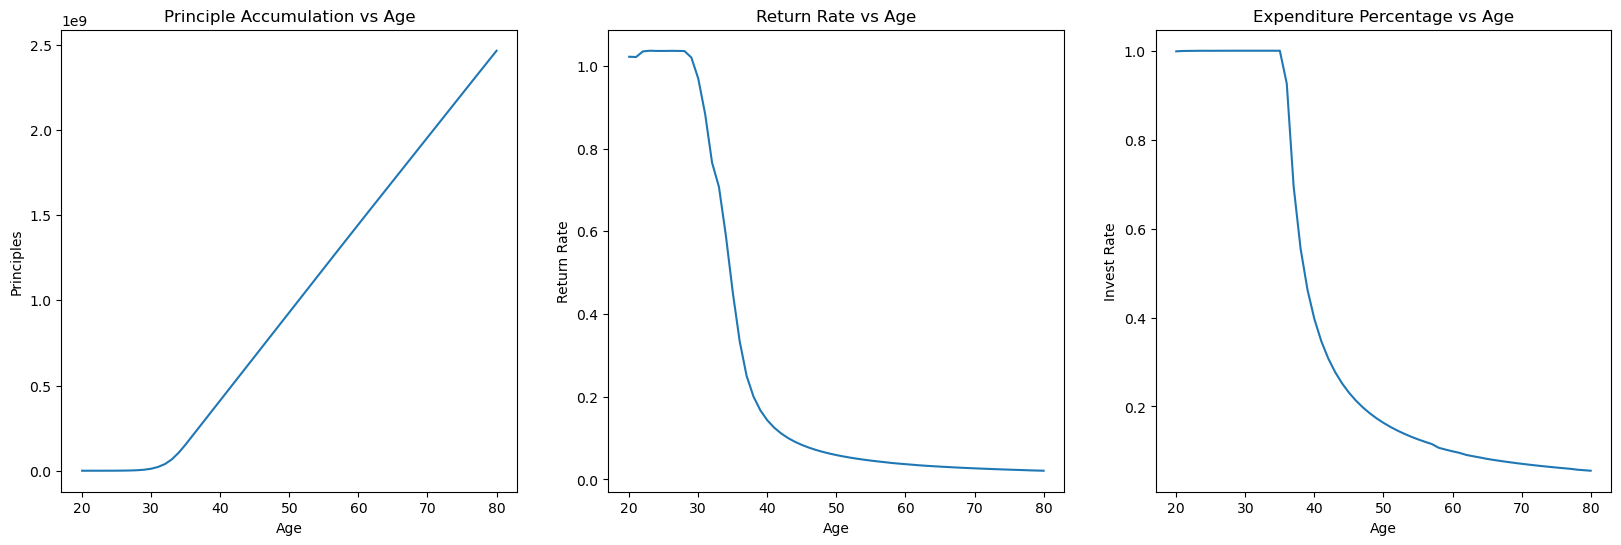

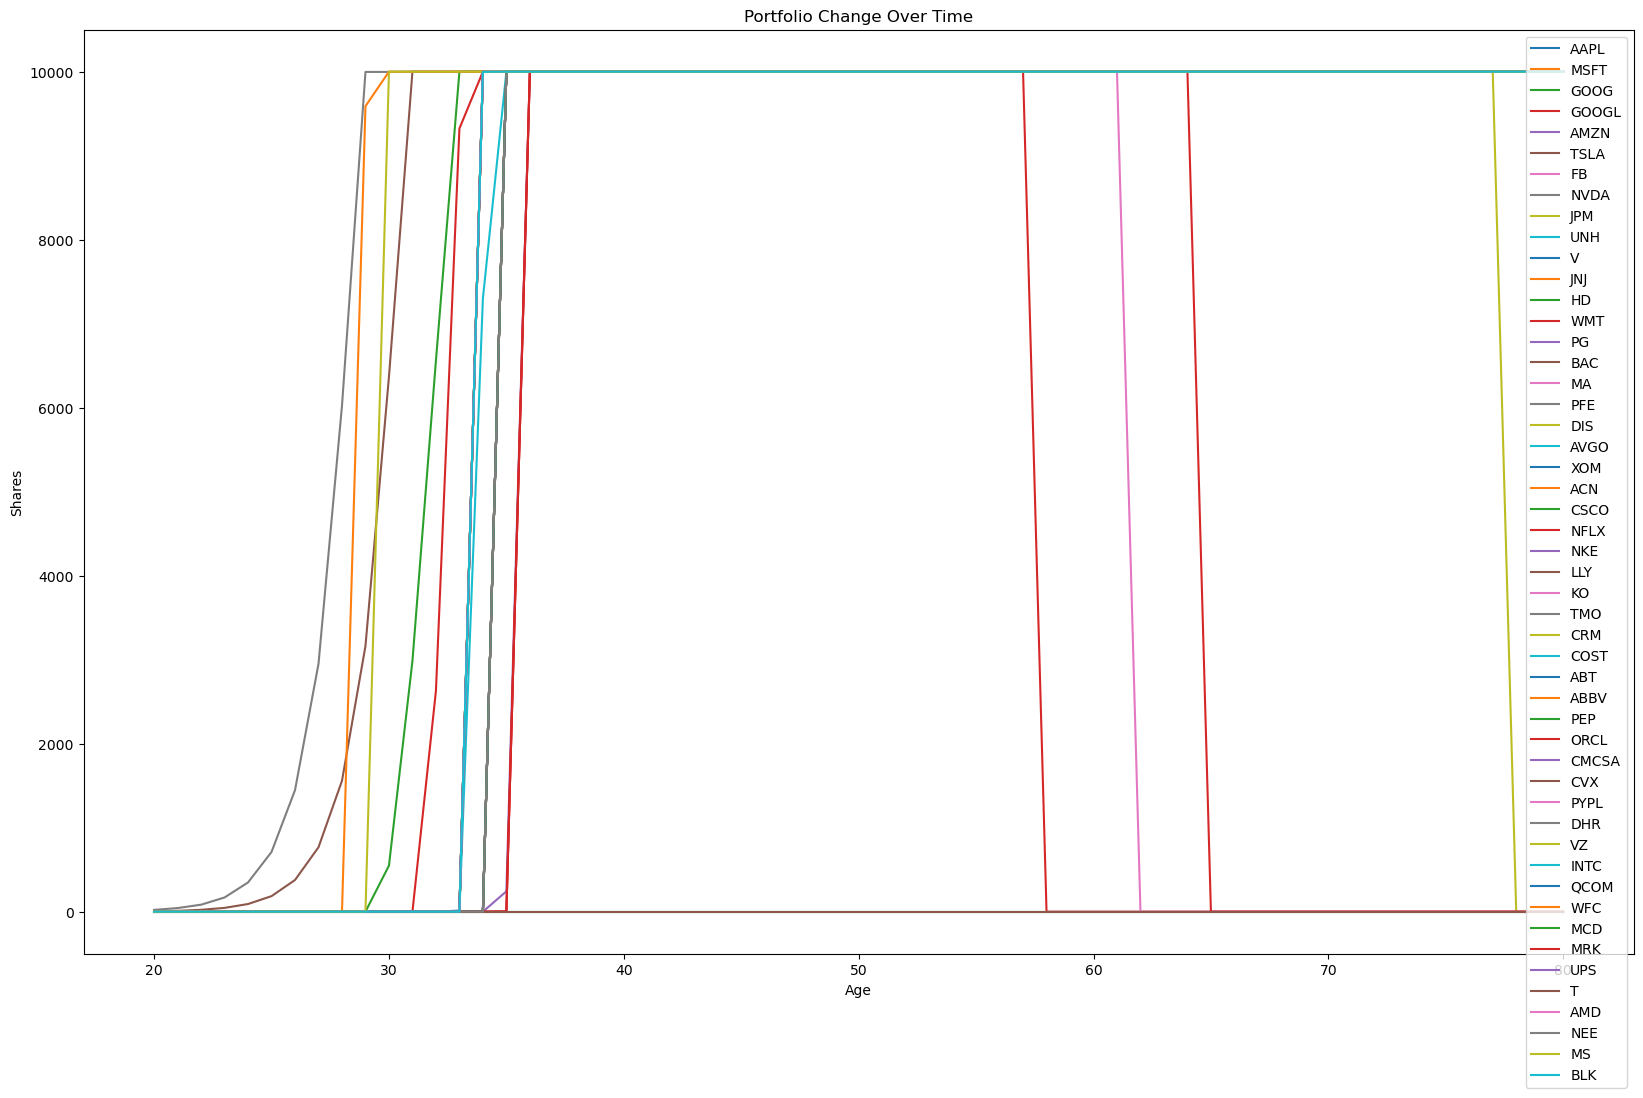

PyObject Text(0.5, 1.0, 'Portfolio Change Over Time')

In [45]:
figure(figsize=(20,6))
subplot(1,3,1)
plot(ages, principles)
xlabel("Age")
ylabel("Principles")
title("Principle Accumulation vs Age")

subplot(1,3,2)
plot(ages, real_ret)
xlabel("Age")
ylabel("Return Rate")
title("Return Rate vs Age")

subplot(1,3,3)
plot(ages, invest_rate)
xlabel("Age")
ylabel("Invest Rate")
title("Expenditure Percentage vs Age")

figure(figsize=(20,12))
plot(ages,portfolio)
legend(stocks)
xlabel("Age")
ylabel("Shares")
title("Portfolio Change Over Time")

Here we created a function that includes every step in creating a portfolio for the convenience of our discussion.  
**Function Parameters:**  
lambda = $ \lambda $  
cur_age = $ i $  
retire = $ i_n $  
princ = $ Principle P $  
squota = $ ShareQuota $  
  
if PGraphMode == 0, display Portfolio line graph  
if PGraphMode == 1, display Portfolio Dataframe  
if PGraphMode == anything else, display nothing  
  
if ToCSV == True, print portfolio into a CSV file called Portfolio.csv

In [46]:
function generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, lambda, cur_age, retire, princ, squota, PGraphMode, ToCSV)

    nStocks = length(stocks)
    dataset = [] # format: ["Stock Name", "Mean return", "Std of return", "AvgClose"]
    for i in stocks
        start = to(from(Marketdata[findfirst(x->x== i, stocks)], buyStart),buyEnd)
        _end = to(from(Marketdata[findfirst(x->x== i, stocks)], sellStart),sellEnd)
        buyin = values(start["Close"])
        sellout = values(_end["Close"])
        exp_ret= []
        exp_ret = sellout - buyin
        for j in 1:length(buyin)
            exp_ret[j] = exp_ret[j] / buyin[j]
        end
        m = mean(exp_ret)
        st = std(exp_ret)
        entry = [i m st mean(buyin)]
        push!(dataset,entry)
    end
    
    close = []
    returns = []
    stds = []
    for i in 1:nStocks
        push!(close,dataset[i][4])
        push!(returns,dataset[i][2])
        push!(stds,dataset[i][3])
    end
    
    
    # Personal information
    
    λ = lambda
    # i = currrent age
    i = cur_age
    # i_n = age to stop investing
    i_n = retire
    # P = principle
    P = princ
    # Stock Quota = Maximum number shares of a stock that you can buy
    shareQuota = squota
    
    
    # Optimization
    portfolio = []
    real_ret = []
    principles = []
    invest_rate = []
    #push!(principles, P)
    for age in i:i_n
        risk_averseness = ((λ/100 + 1) / (1+ ℯ^(0.07*age - 5))) - 1
        m = Model(with_optimizer(Gurobi.Optimizer, OutputFlag=0, GUROBI_ENV))

        pQuota = ((95/200) * risk_averseness * 100 + 52.5) / 100
        
        @variable(m, integer=true, x[1:nStocks] >= 0 )
        for i in 1:nStocks
            @constraint(m,x[i] * close[i] <= (pQuota * P)) # Constraining amount of money in each stock
            @constraint(m,x[i] <= shareQuota) # Constraining number of shares in each stock
        end
        @constraint(m,sum(x[i] * close[i] for i in 1:nStocks) <= P) # Constraining investing budget

        @objective(m, Max, sum(x[i] * close[i] * (returns[i] + risk_averseness*stds[i]) for i in 1:nStocks))
        optimize!(m)
        push!(portfolio, value.(x))
        profit = 0
        expenditure = 0;
        for i in 1:nStocks
            profit += value.(x)[i] * close[i] * returns[i]
            expenditure += value.(x)[i] * close[i]
        end
        push!(invest_rate, expenditure/P)
        push!(real_ret, profit/P)
        P += profit
        push!(principles, P)
    end

    # Result Display for return rate
    ages = i:i_n
    ret_df = DataFrame(Ages = ages)
    ret_df[!,:Return_rate] = real_ret
    #println(ret_df)
    
    figure(figsize=(20,4))
    subplot(1,3,1)
    plot(ages, principles)
    xlabel("Age")
    ylabel("Principles")
    title("Principle Accumulation vs Age")
    
    subplot(1,3,2)
    plot(ages, real_ret)
    xlabel("Age")
    ylabel("Return Rate")
    title("Return Rate vs Age")
    
    subplot(1,3,3)
    plot(ages, invest_rate)
    xlabel("Age")
    ylabel("Invest Rate")
    title("Expenditure Percentage vs Age")
    
    
    port_df = DataFrame(Stock_Symbol = stocks)
    for i in 1:length(portfolio)
        colname = ages[i]
        port_df[!,Symbol.("Age:", ages[i])] = portfolio[i]
    end
    
    if(PGraphMode == 0)
        figure(figsize=(20,8))
        plot(ages,portfolio)
        legend(stocks)
        xlabel("Age")
        ylabel("Shares")
        title("Portfolio Change Over Time")
    elseif(PGraphMode == 1)
        # Result Display for Portfolio
        display(port_df)
    end
    
    if(ToCSV == true)
        # Save to csv
        CSV.write("Portfolio.csv", port_df)
    end
#     return dataset
end

generatePortfolio (generic function with 1 method)

## 4. Results and discussion ##


For our preliminary results, we've found that as a person gets more risk averse, their investment strategy changes to produce a non-trivial change in their expected returns. Basically, as a person's age increases, they invest in stocks that are less volatile, and end up having lower overall return rates (over a one year period). This will come to change with shorter investment intervals, where shorter intervals will yield investments into more volatile stocks that are profitable to hold for only a short interval of time (the concept of "day trading" a stock for a limited amount of time comes to mind). 

Our client suggested comparing which stocks changed with our problem parameters and variables which we have incorporated into our large 'Portfolio Change Over Time' graphs. Our client also wanted us to discuss which stocks did not change, or were ignored, but we felt this was out of the scope of our current project objective to simply find the optimal stock portfolio (focusing on which stocks were included).

 
<!-- ### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

We are going to use the level of risk-aversion as a tradeoff parameter to determine the best outcomes for risk-averse, risk-neutral, and risk-loving individuals and compare the outcomes in a bar chart graph in order to derive the relationship between the level of risk-aversion and the life-long investment return. For this relationship, we anticipate that there will be a clear strictly-increasing pattern. 

Also, we are interested in the change that takes place over time as individuals get older and, as in most cases, more fiscally conservative. The plan is to give individuals a starting salary at 22 years old and calculate the profit for each year while changing the risk-aversion level based on the individual’s income growth and personality, and analyze how the portfolio changes over the years. 

We plan to run a senstivity analyisis on our variables to experiment with the effects of changing the principle $P$ and risk-averseness $\lambda$.

Further, we may explore how inflation – calculated on price indices such as CPI or PCE – affects the percentage of income the user can invest. -->


### 4.1 Principle Changes

Here we will analyze the effect of our principle constraint by comparing different initial principles. For all these cases, we are going to set the lambda as -50, retirement age at 90, and shares quota as 100,000 shares per stock, with the default investment period as 1 year.

In [47]:
buyStart = Date(2020,4,20)
buyEnd = Date(2021,4,19)

sellStart = Date(2021,4,19)
sellEnd = Date(2022,4,15)

t_lambda = 0
t_cur_age = 20
t_retire = 80
shares_quota = 100000
print_portfolio = 2
print_csv = false

false

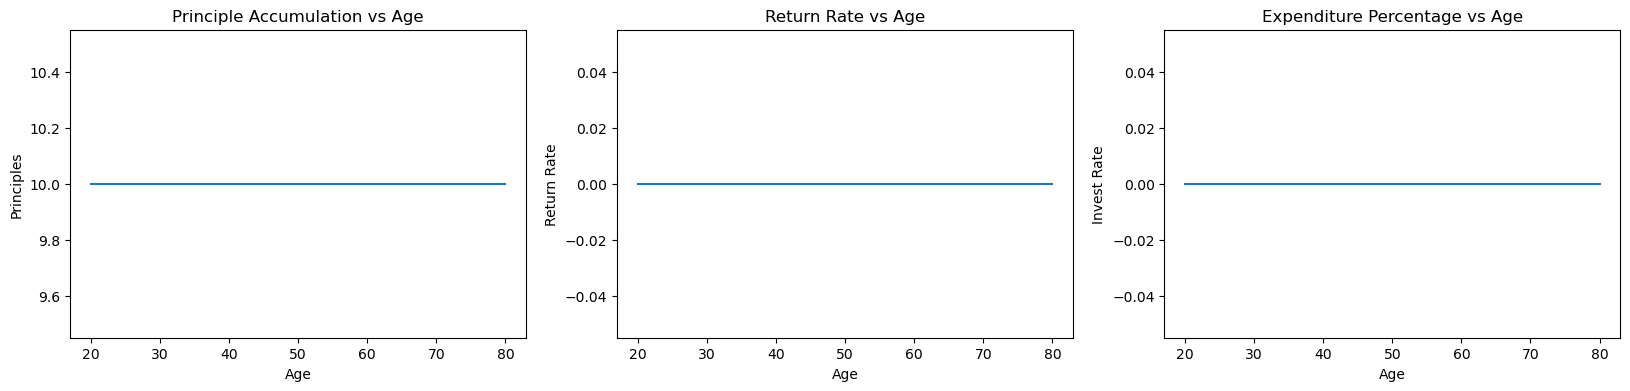

In [48]:
# Case 1: initial principle $10
ini_princ = 10
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

We do want to see if we can start with the cash that we picked up by the sidewalk this morning. But it is turned out that we can buy no share at all within the current stock set because of the high price per share. So there will be no gain at all to enable you to buy more stocks.

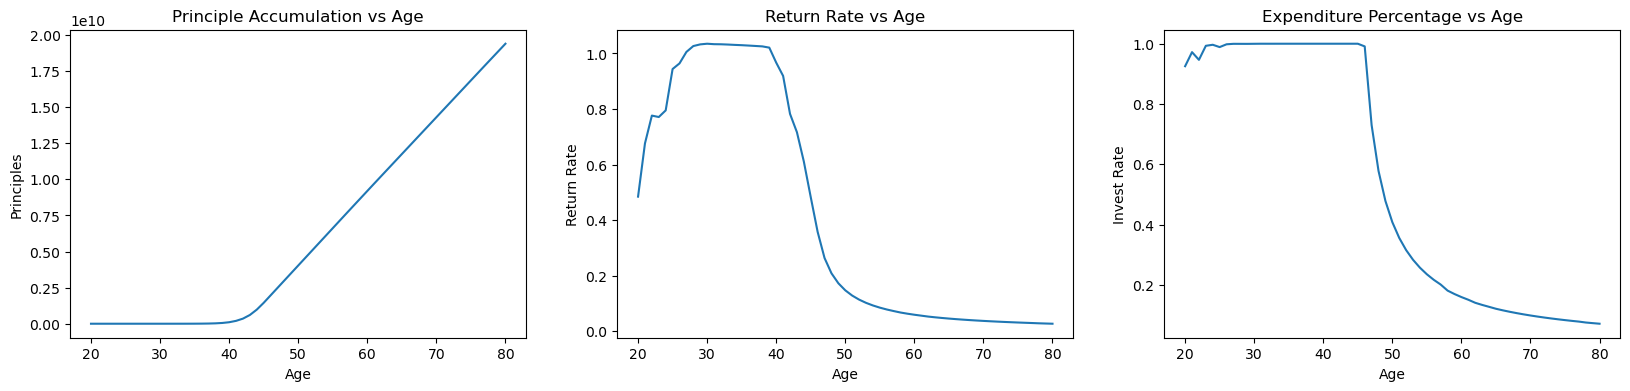

In [49]:
# Case 2: initial principle $100
ini_princ = 100
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

With $100 input, it is possible to start investing in stock market. Now the best strategy can help us to quickly accumulate wealth. The return rate graph showed us that with a tiny initial principle, it will take about ten years to reach a point that we can maximize our "profitability."

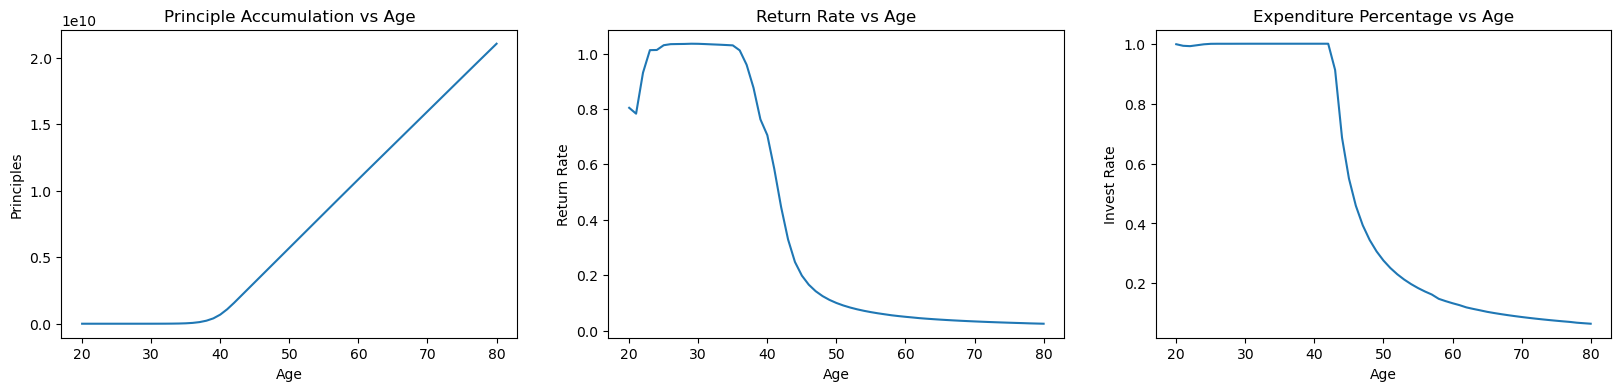

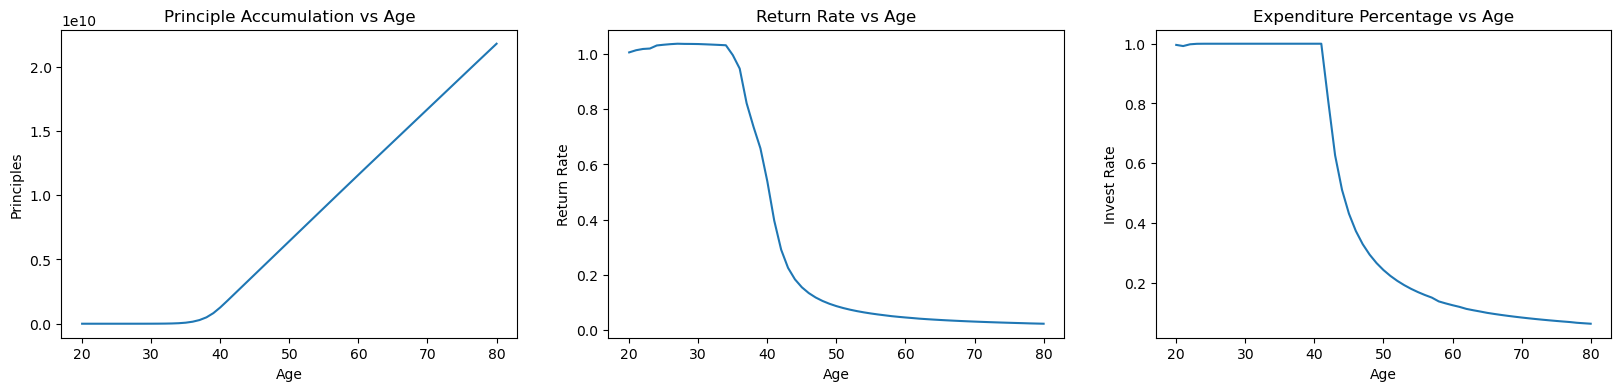

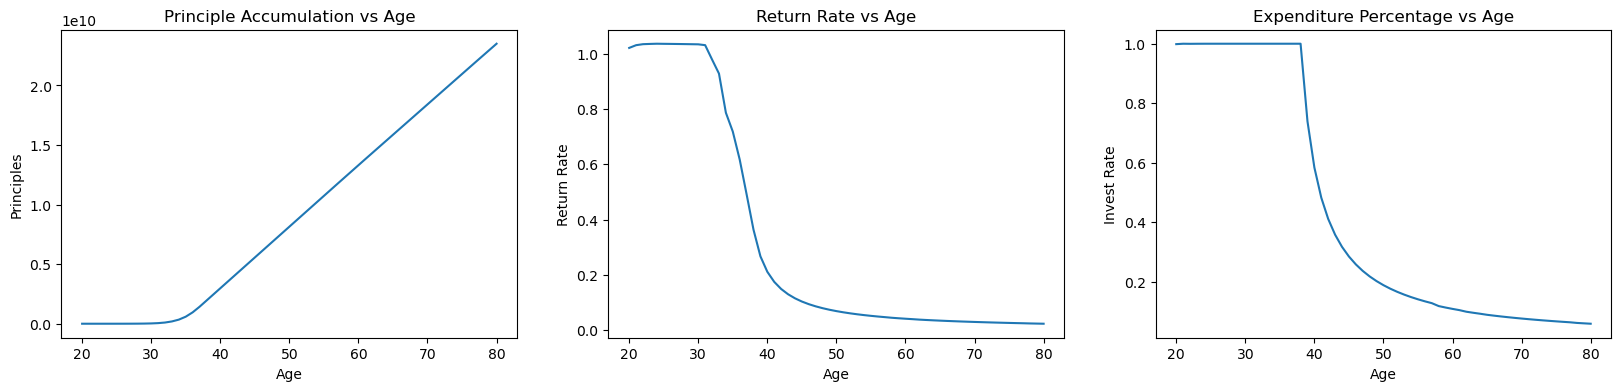

In [50]:
# Case 3,4,5: initial principle $500, $1000, $10000
ini_princ = 500
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)
ini_princ = 1000
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)
ini_princ = 10000
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

By comparing these sets of graphs that generated by different initial principles, we can see that with a higher initial principle, one will be able to get the optimal portfolio that gives the highest return rate earlier in the life time. Because of that, a higher initial principle can give us more years in maximal profitable portfolio, thus increasing our lifetime income.

### 4.2 Quota Changes

Here we will analyze the effect of our shares quota constraint by comparing different shares quotas. For all these cases, we are going to set the lambda as 0, retirement age at 90, and initial principle as $10000, with the default investment period as 1 year.

In [51]:
buyStart = Date(2020,4,20)
buyEnd = Date(2021,4,19)

sellStart = Date(2021,4,19)
sellEnd = Date(2022,4,15)

t_lambda = 0
t_cur_age = 20
t_retire = 80
ini_princ = 10000
print_portfolio = 0
print_csv = false

false

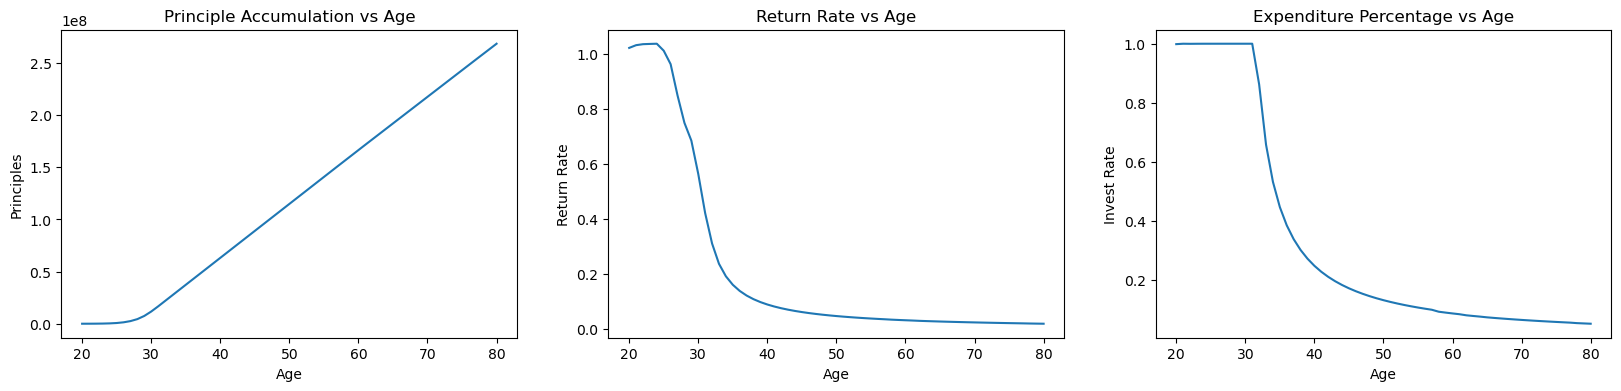

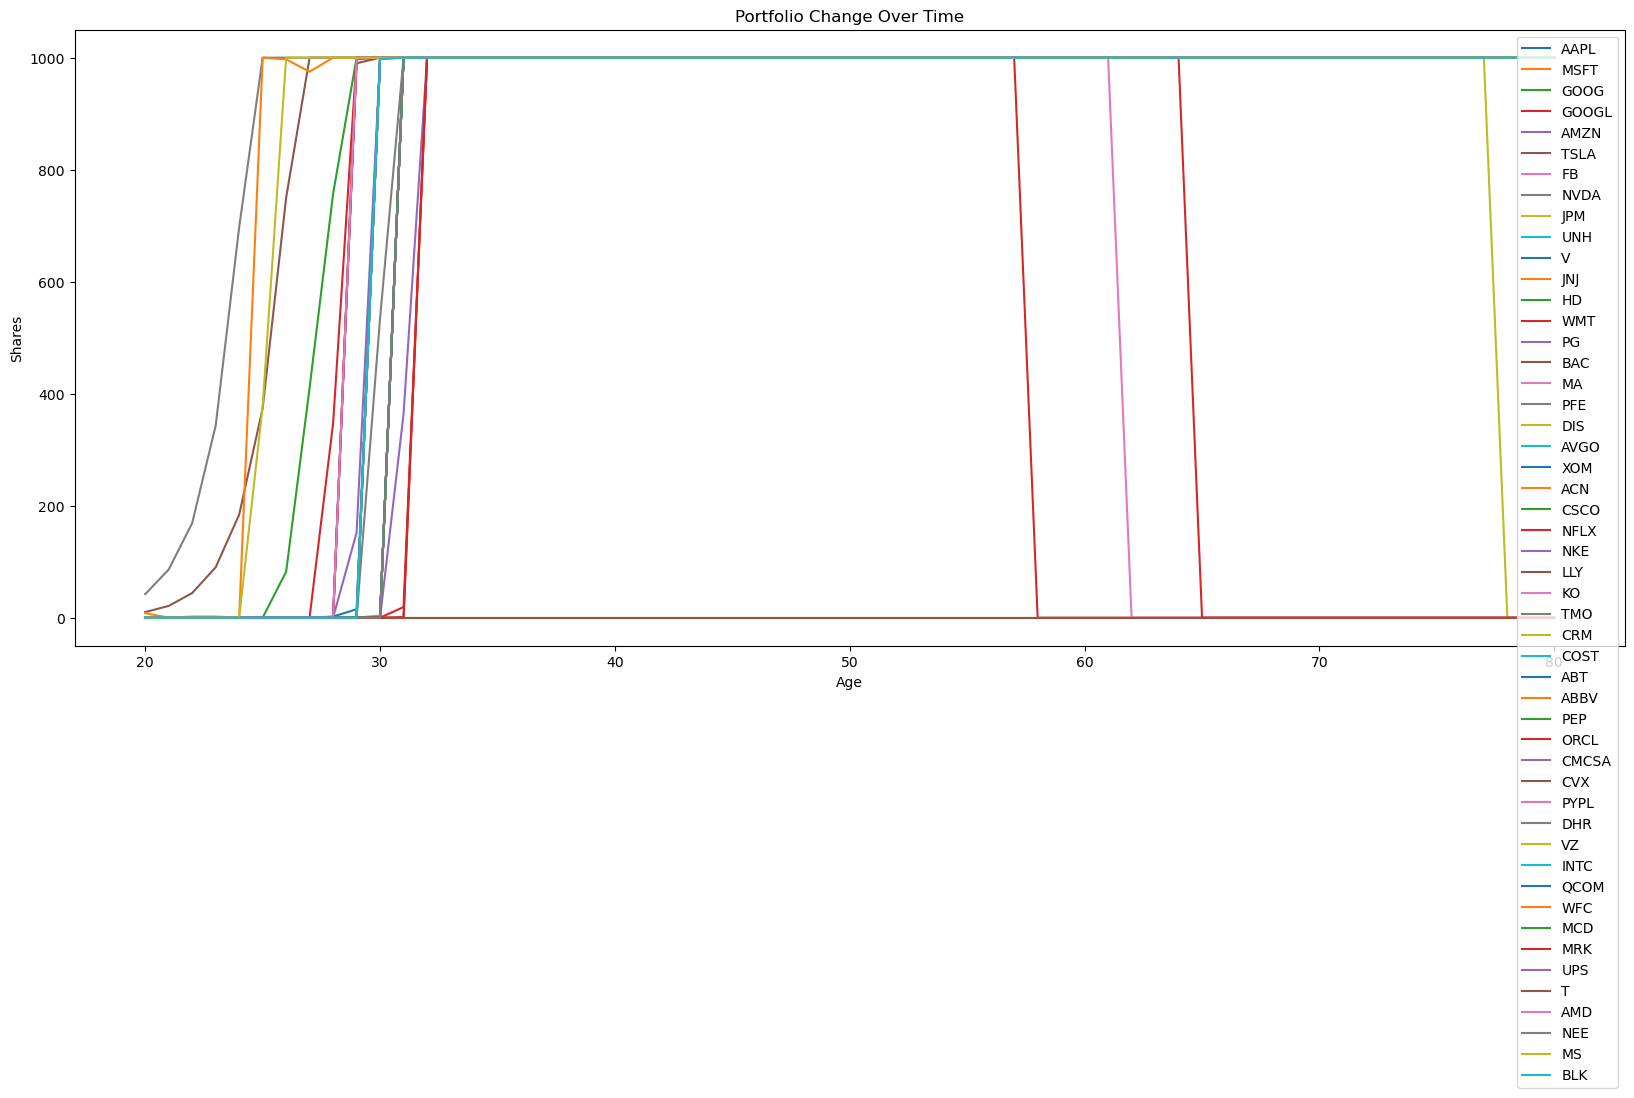

In [52]:
# Case 1: quota 1,000 shares
shares_quota = 1000
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

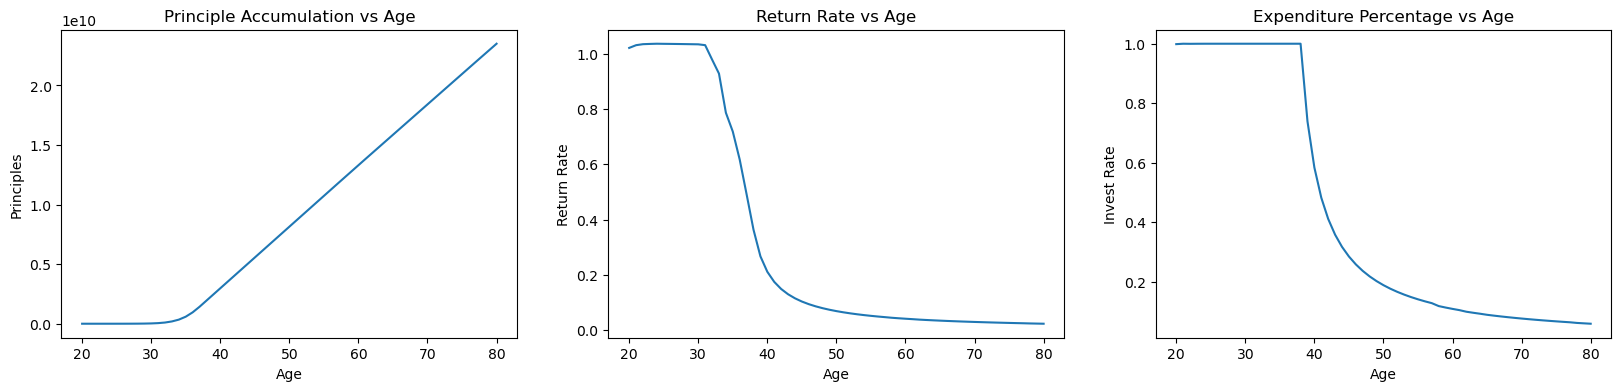

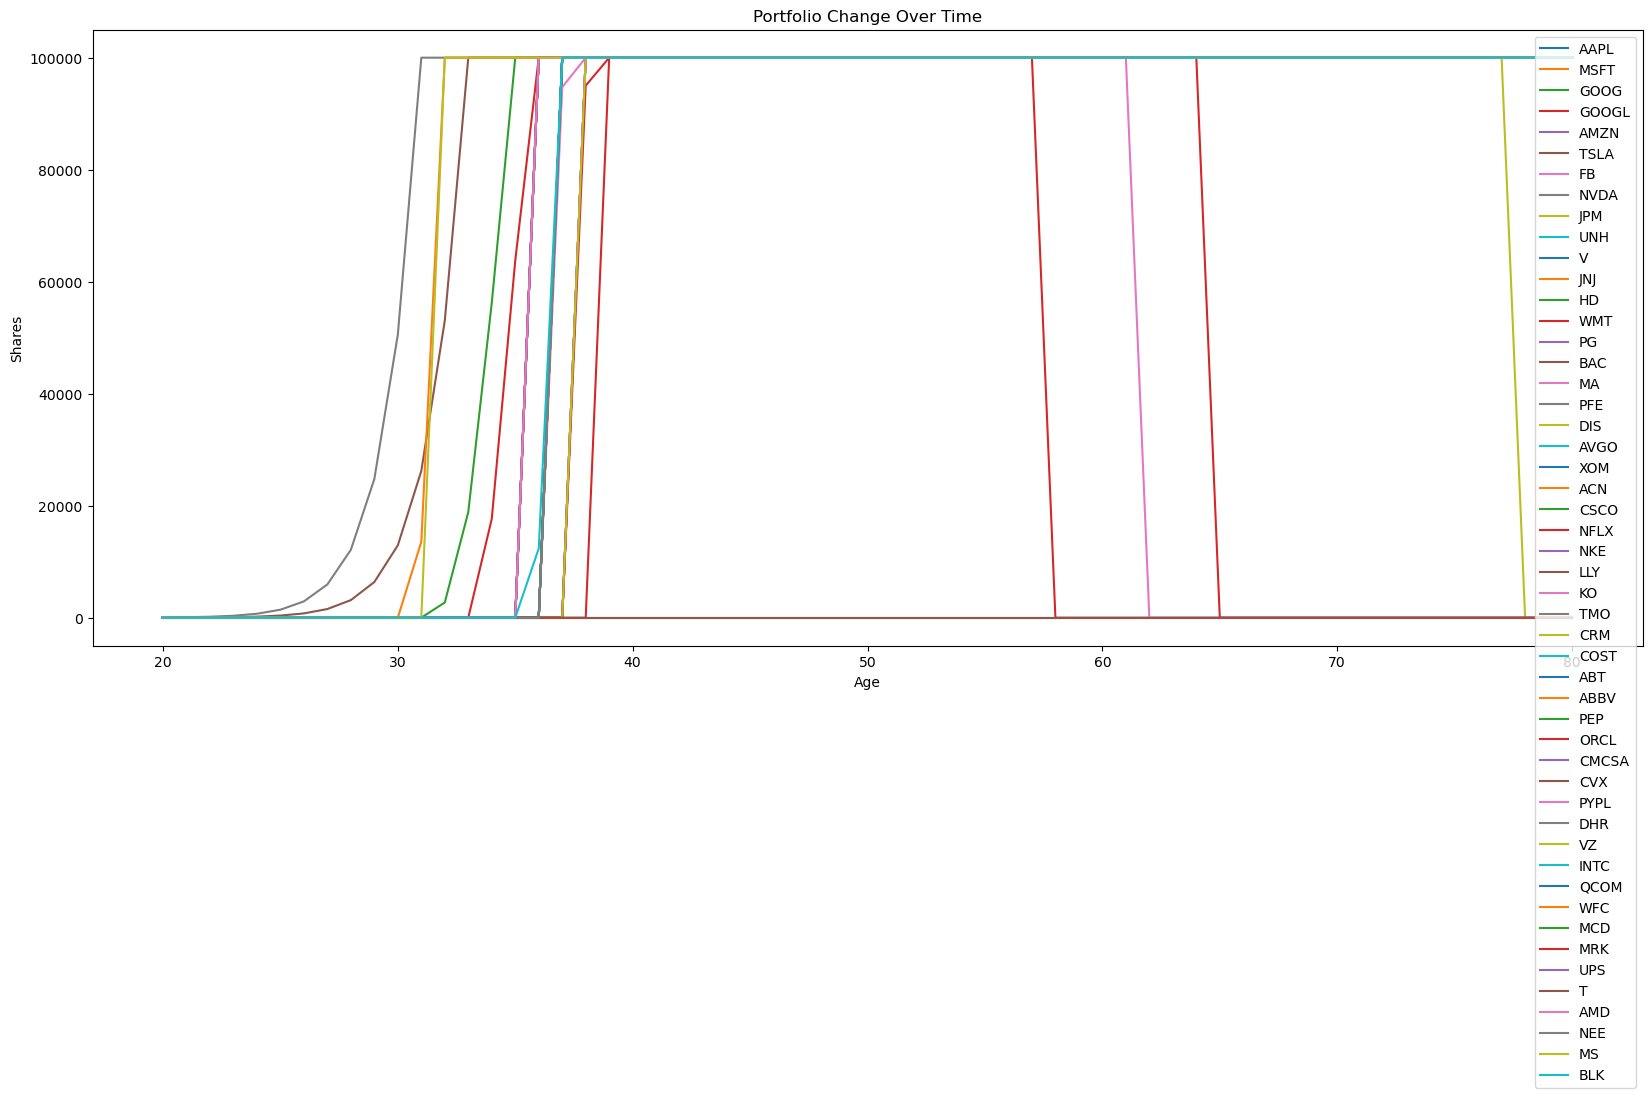

In [53]:
# Case 2: quota 100,000 shares
shares_quota = 100000
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

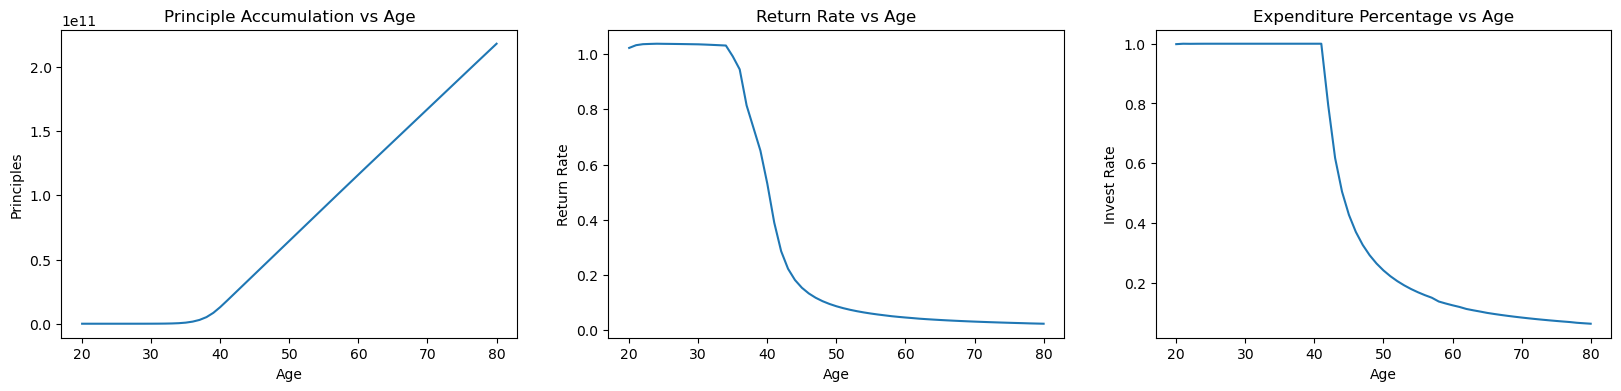

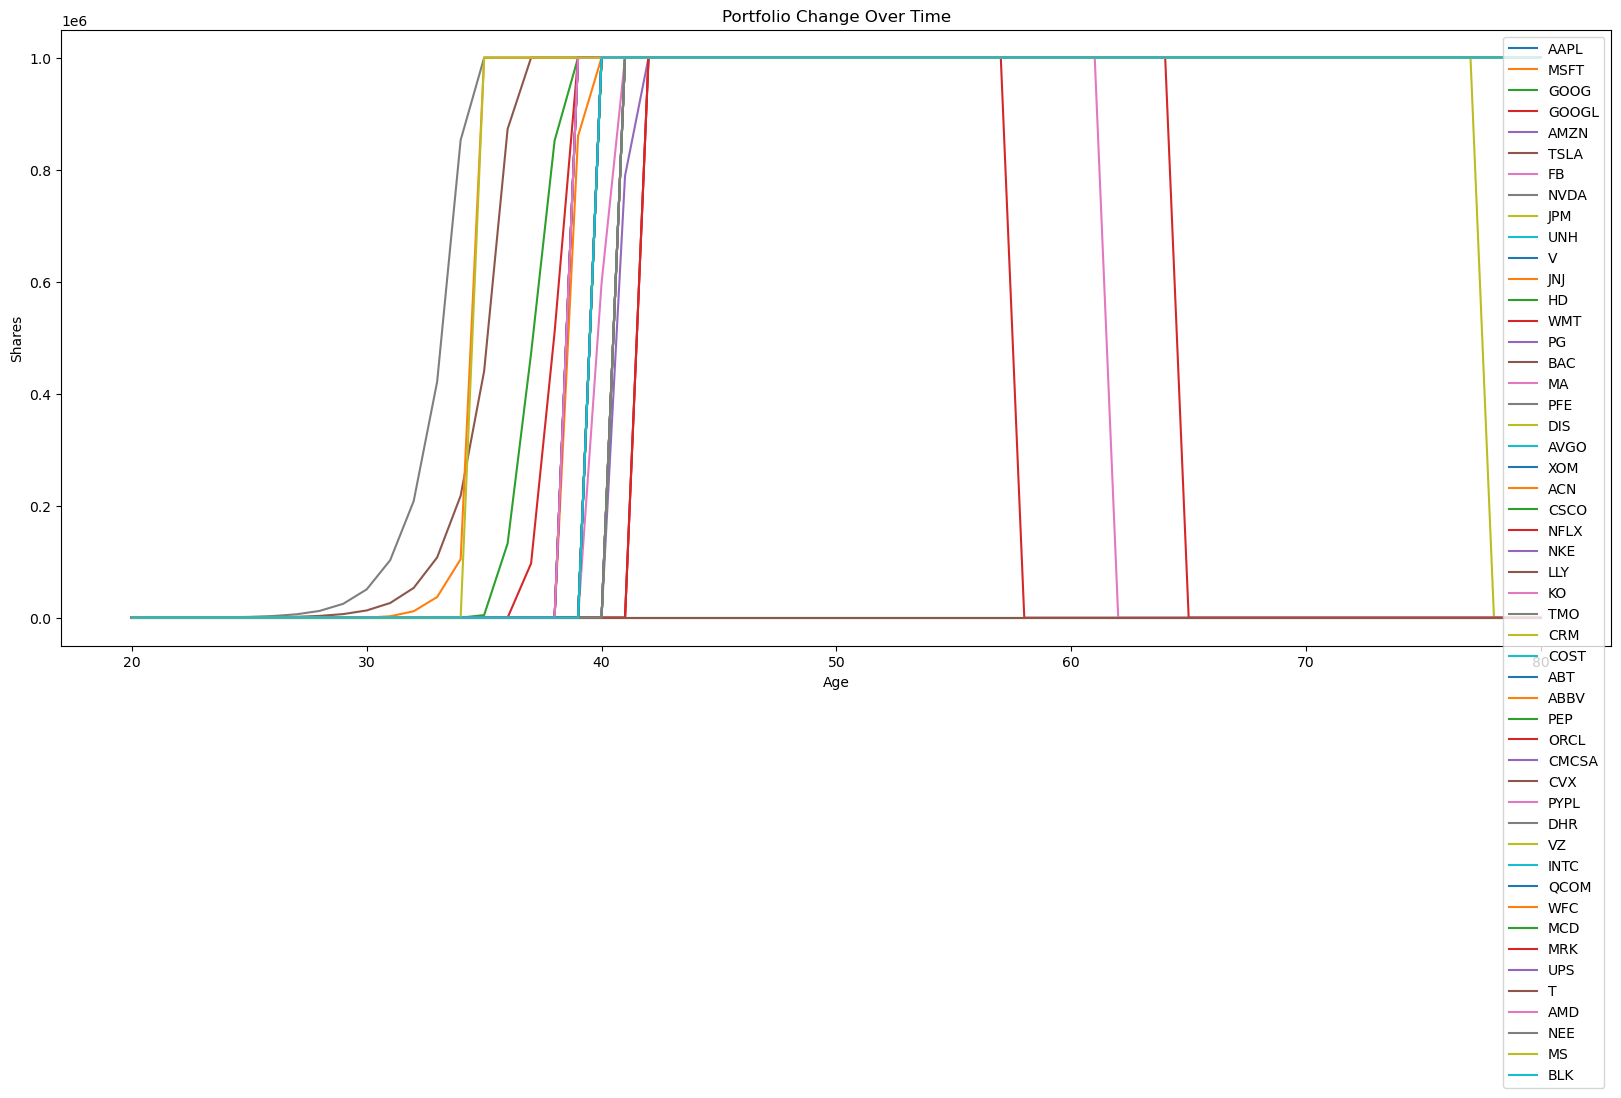

In [54]:
# Case 3: quota 1,000,000 shares
shares_quota = 1000000
generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

In the previous three cases, what we can see is that it takes longer time to buy all qualified stocks to their shares quota if we have a higher share quota. At the same time, holding more shares in the same stocks also means that you can profit while having the same return rate. So the final wealth after the retirement is also going to vary based on share quotas. There is no difference in the timeline of "deinvesting stocks" phase, which means some stocks become negative properties for you because of your increasing risk-averseness.

## 4.3 Analysis Over Varying Investment Periods

Here we discuss the effect of lambda in determining differences of risk-indifferent, risk-loving, and risk-averse investors over a lifetime by comparing their varying interesting investments based on our model's predictions for an optimal portfolio by collecting different amounts of data from across 1-year, 6-month, 3-month, and 1-month periods.

### 4.3.A 1-Year Investment Frame

In this cell, we analyze the findings after setting the buy and sell periods as one year. More specifically, comparing a risk indifferent (λ = 0) investor, risk loving (λ = 75) investor, and a risk averse (λ = -75) investor.

**Risk Indifferent Individual**

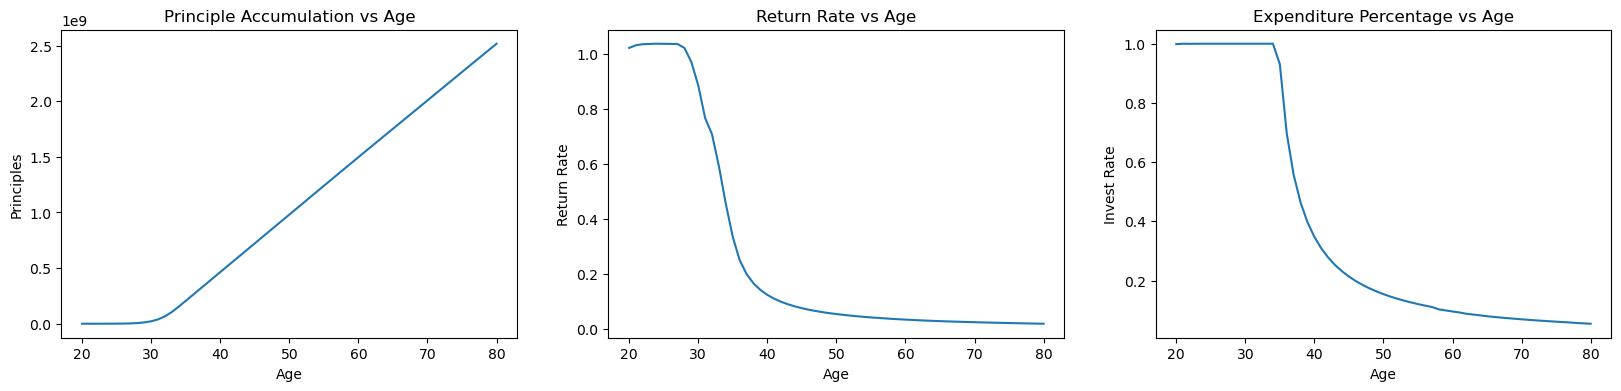

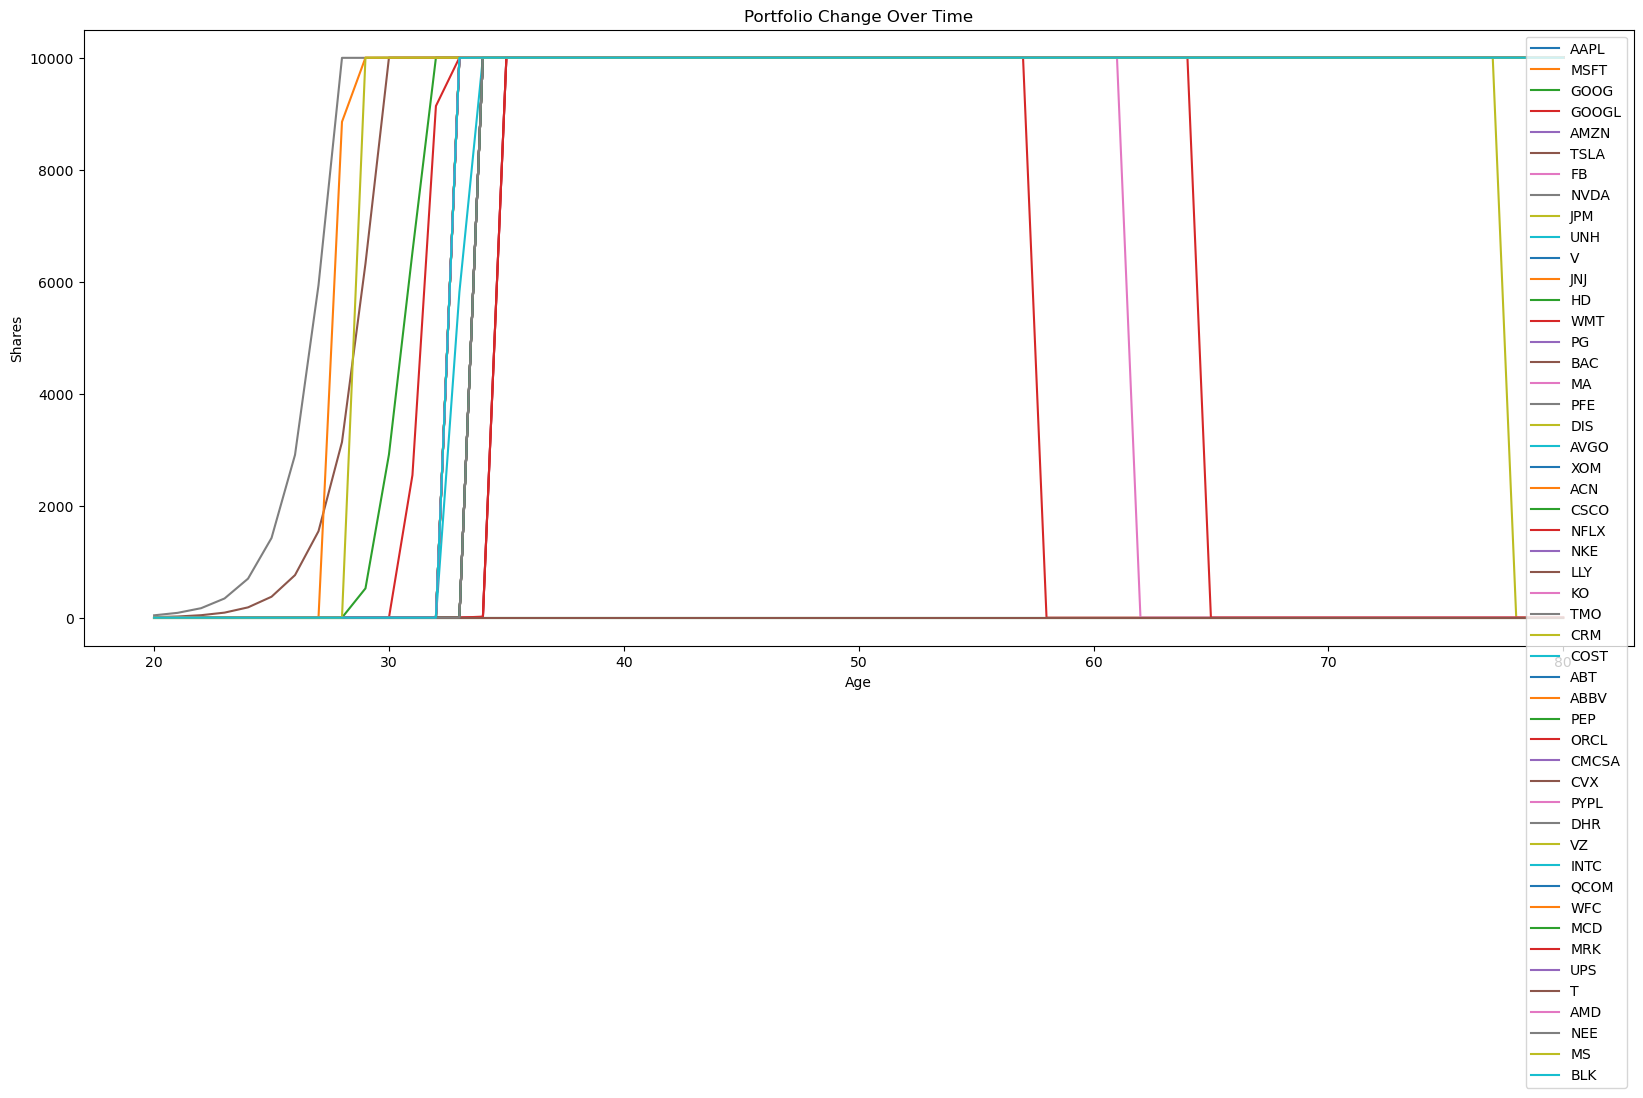

In [55]:
# 1-year data collection
buyStart = Date(2020,4,20)
buyEnd = Date(2021,4,19)

sellStart = Date(2021,4,19)
sellEnd = Date(2022,4,15)

t_lambda = 0
t_cur_age = 20
t_retire = 80
ini_princ = 10000
shares_quota = 10000
print_portfolio = 0 #toggle between 0 and 1 for a graph or a table representation of the portfolio , or 2 to print nothing
#(note:graph reccomended)  
print_csv = false #toggle to true if you want to view a the portfolio as a CSV file 

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Averse Individual**

Here, we see that the principle accumulation corresponds to the time the individual starts reducing their investing in the stock market. This also corresponds with the portfolio graph (i.e, change in portfolio over time). As for the return rate, this stays at about 80% up until the age of 40, and decreases as the individual stops buying stocks. This corresponds to when the risk level of the equities market becomes too high for this particular individual, and therefore, when they stop adding more stocks to their portfolio. If we included other safer markets, this would most likely be the period where their investments in these low risk markets increase. 

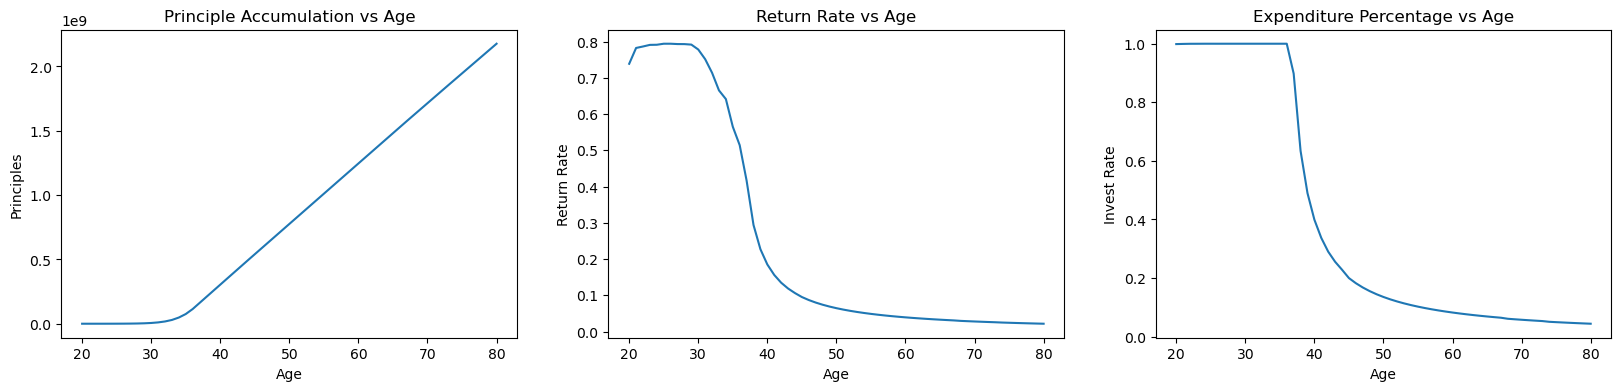

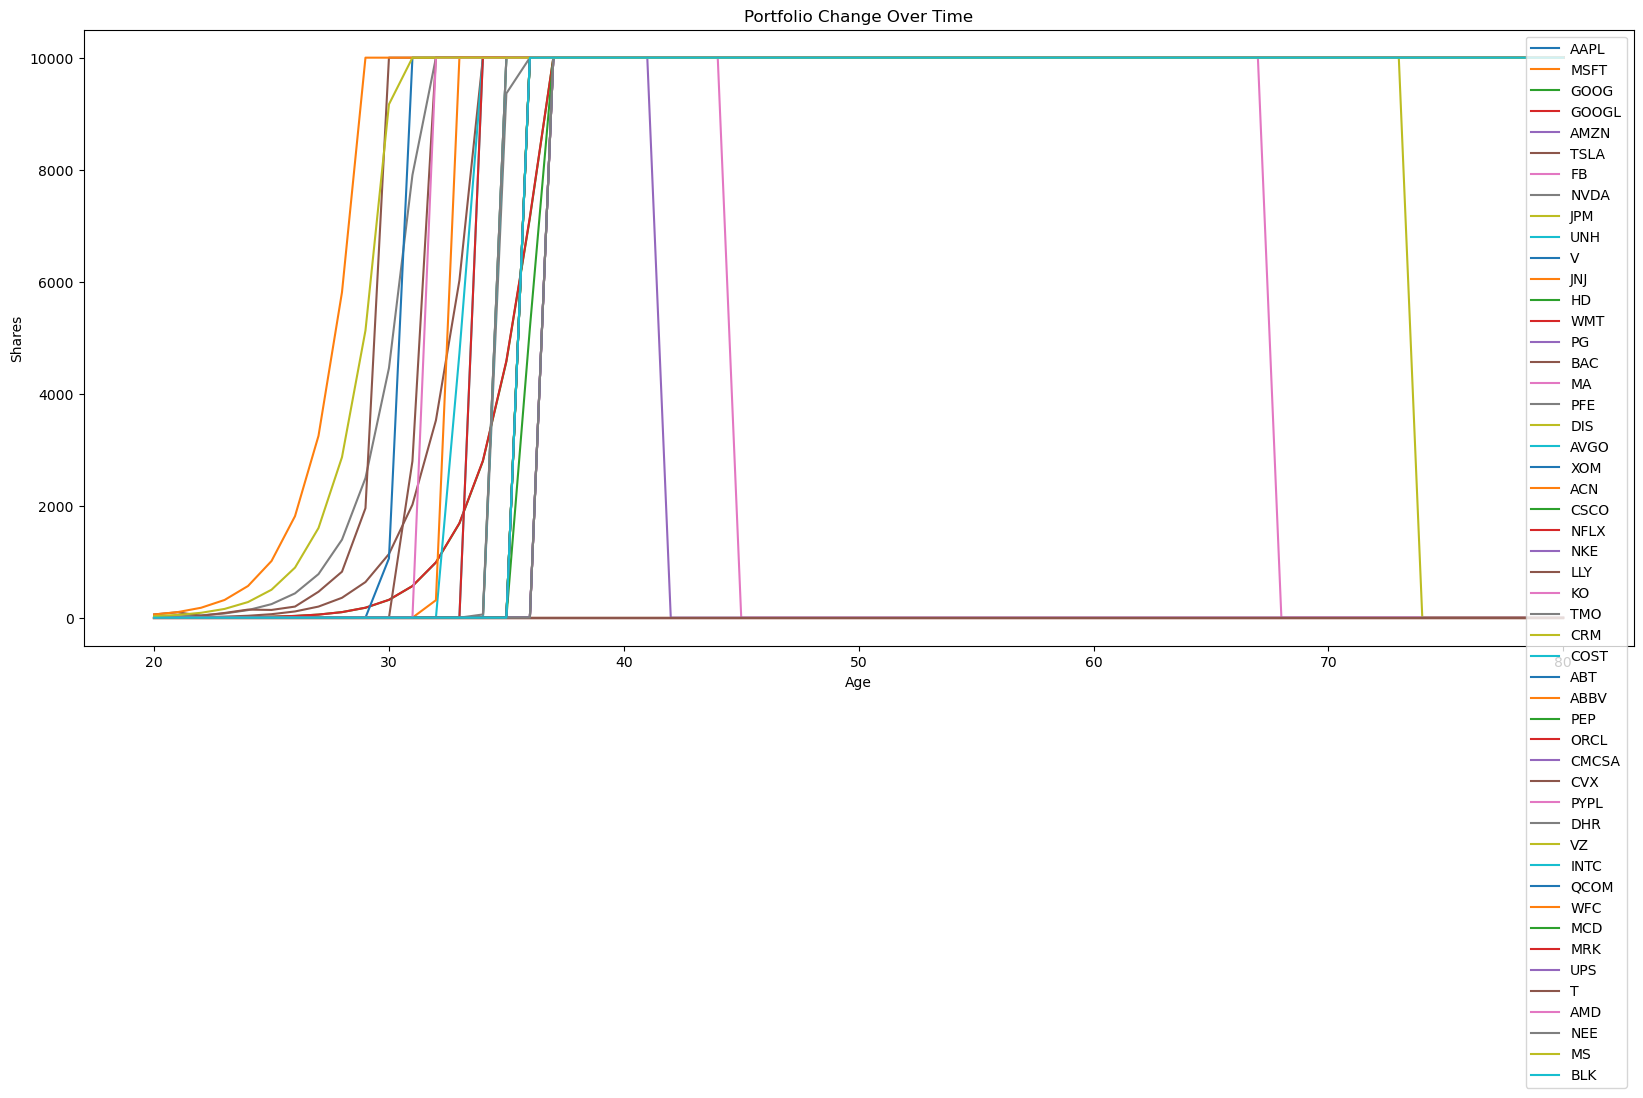

In [56]:
t_lambda = -75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Loving Individual**

Here, we can see that the graphs are more or less the same, with some slight changes in the return rate and the age at which the investor starts reducing their expenditure on equities over time that are expected with the change in risk. The slightly higher return rate is because it the investor is going to favor volatile stocks, which provide a higher return rate (although this is because our model can essentially predict the future becuase it has the data). Secondly, the investor will obviously stop investing at a later age due to their higher risk tolerance. The biggest difference, however, is the diversity of their portfolio. Notice that the risk averse investor has a far more diverse portfolio.

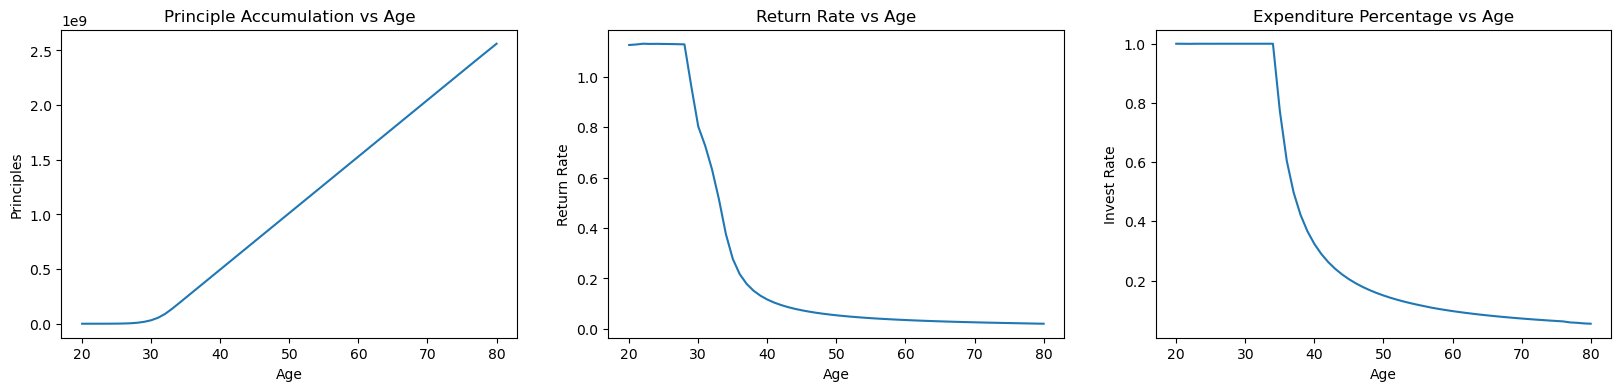

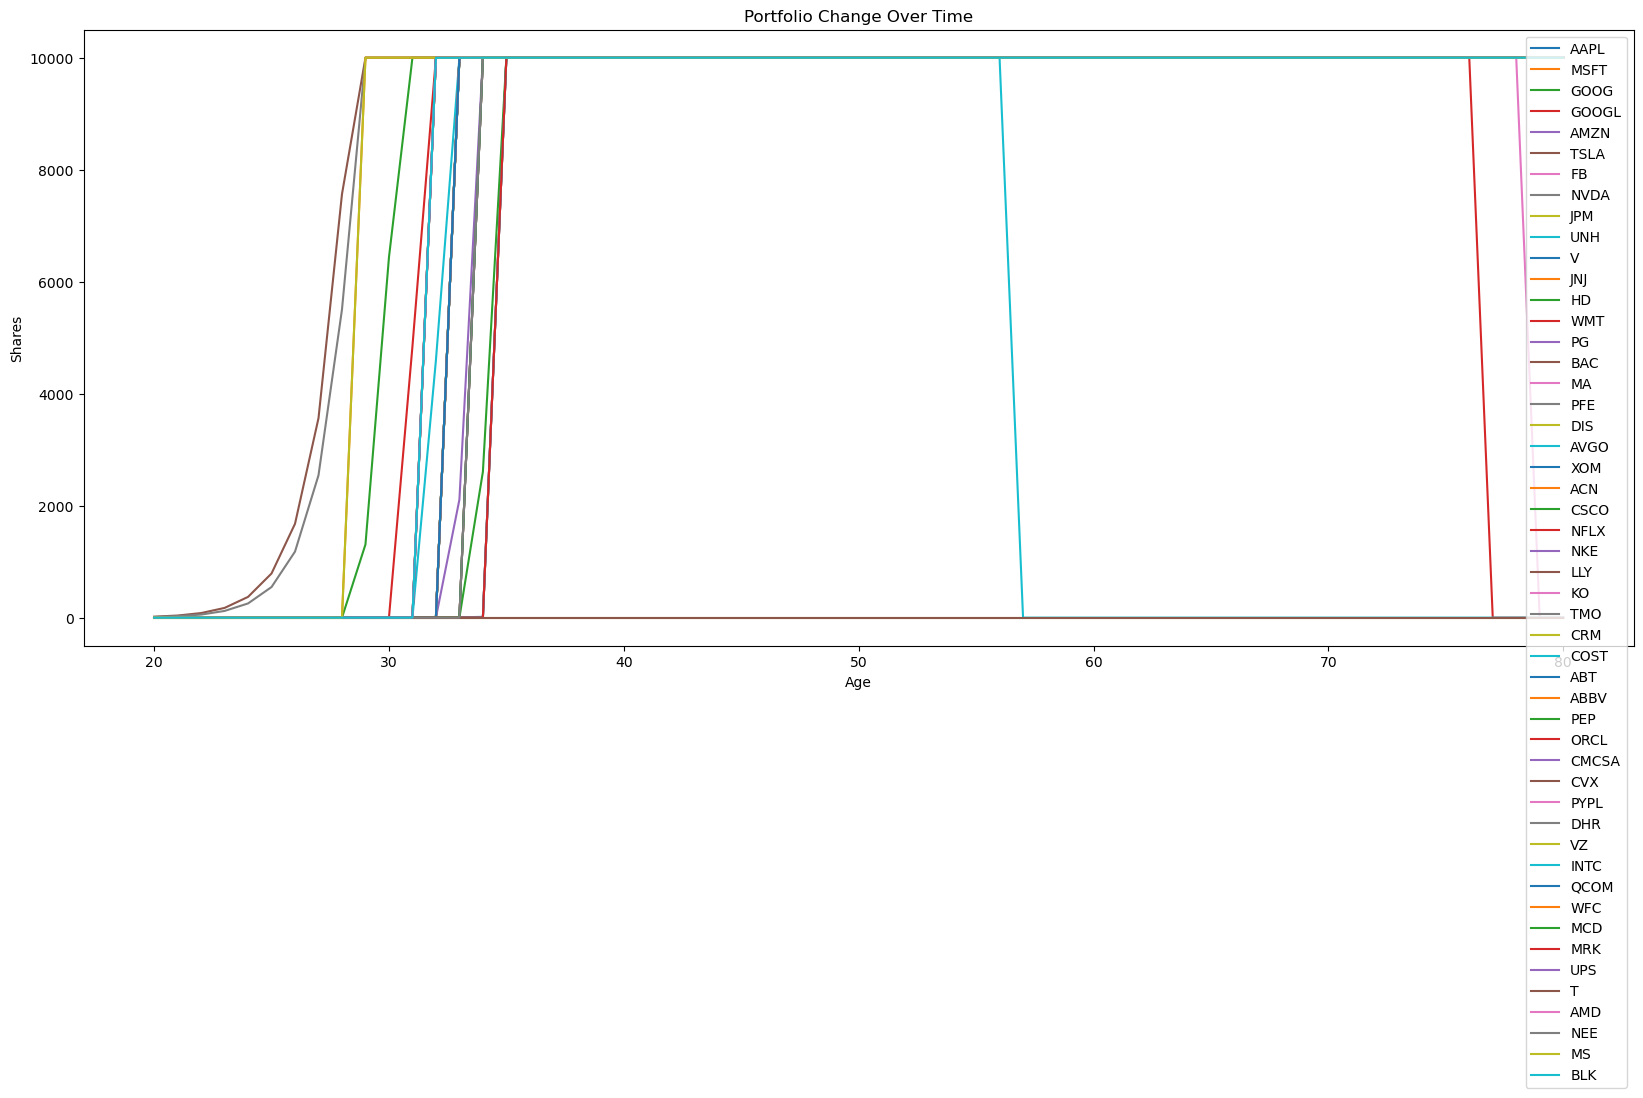

In [57]:
t_lambda = 75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

### 4.3.B 6-Month Investment Frame

This section analyzes the same variables, but with the time frame reduced to six months. 

In general, the 6-month data collection compared to the 1-year data collection yielded:

$\bullet$ The return rate and principle accumulation are much lower on-average.

$\bullet$ Most invesment trading occurs in the middle of an investors life (between ages 30 and 60) rather than early in life (between ages 20 and 40).

$\bullet$ There is an increase in portfolio changes over an investors lifetime.

**Risk Indifferent Individual**

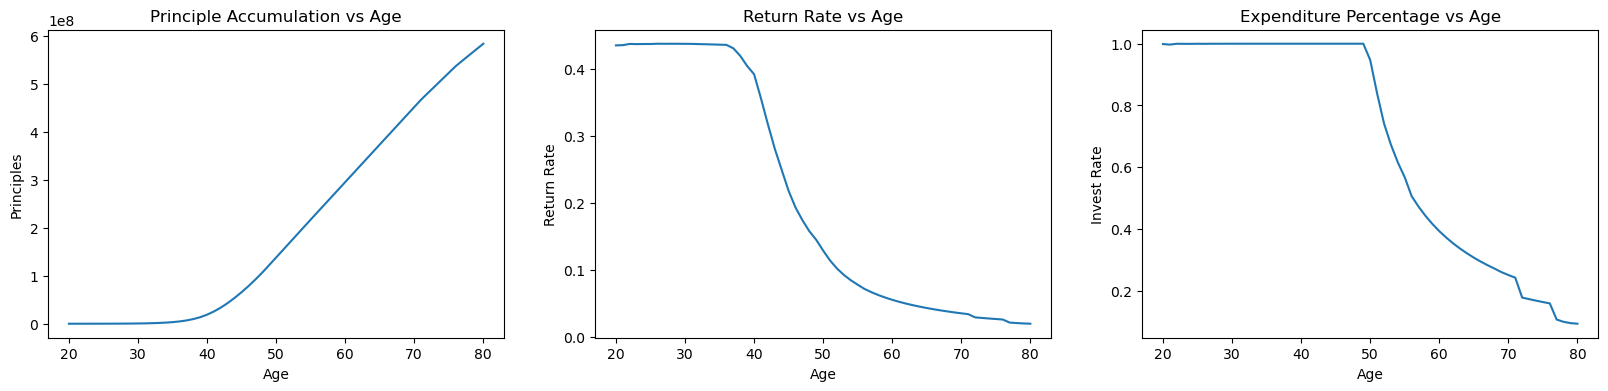

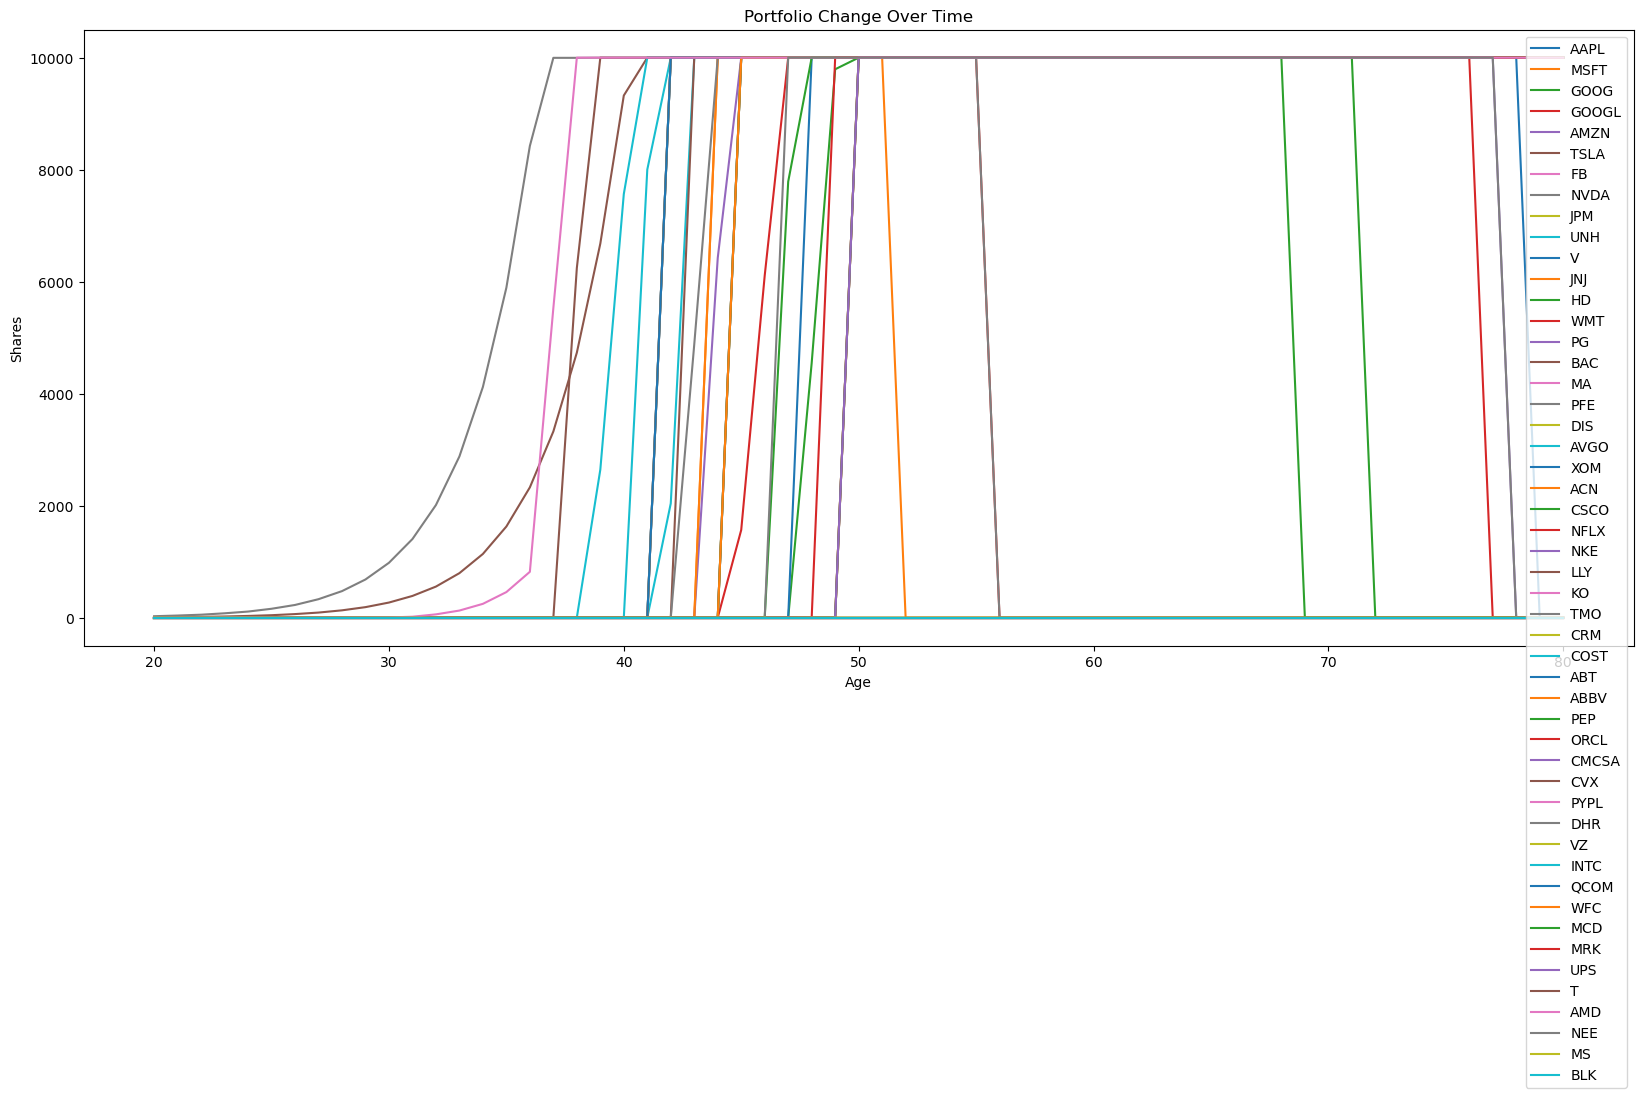

In [58]:
# 6-month risk-indifferent
buyStart = Date(2021,4,22)
buyEnd = Date(2021,10,22)

sellStart = Date(2021,10,22)
sellEnd = Date(2022,4,27)

t_lambda = 0
t_cur_age
t_retire = 80
ini_princ = 10000
shares_quota = 10000
print_portfolio = 0
print_csv = false

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Averse Individual**

Here, we see that the return rate is lower(obviously, since we are investing over a shorter period of time), and that the investor holds out investing a lot longer compared to a one year period. This is probably because the lower return rates elongate the principle accumulation process. Other changes include an increase in the age that the investor starts investing.

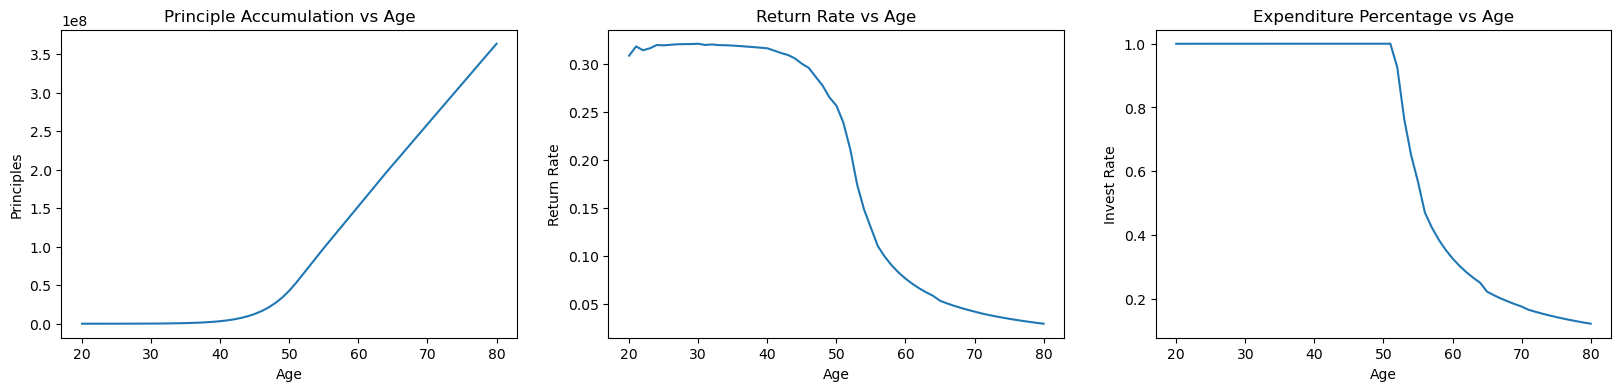

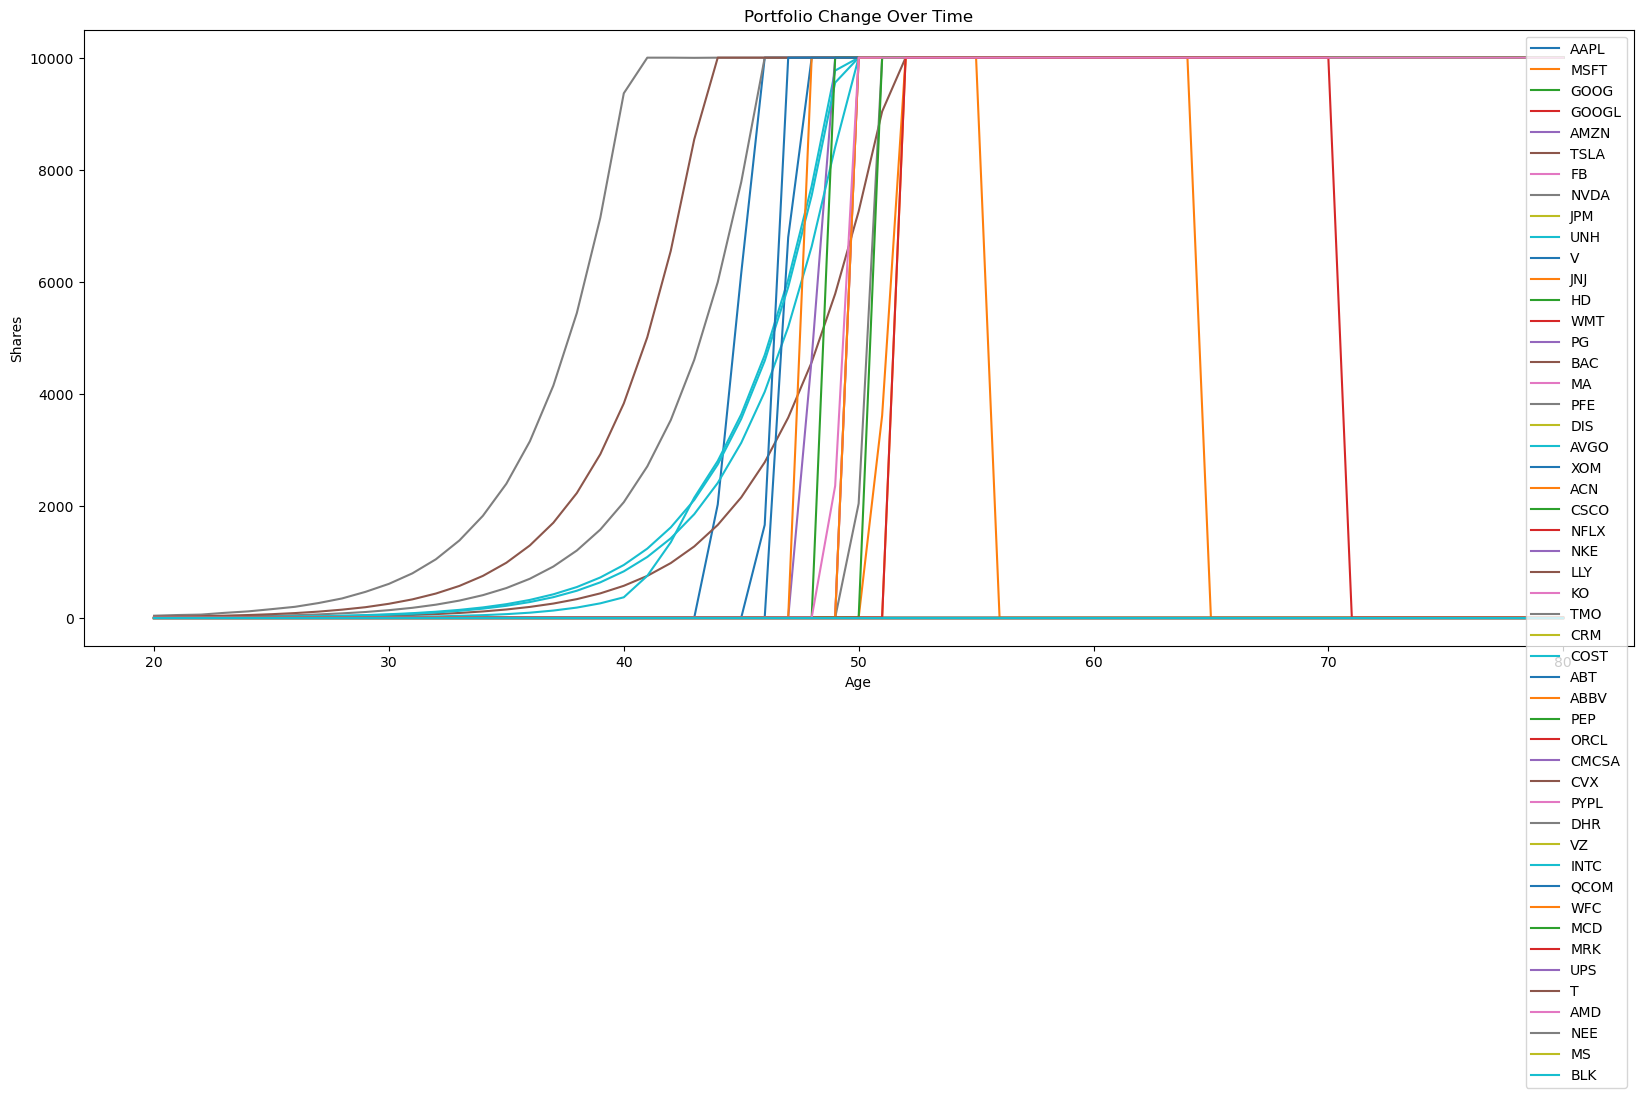

In [59]:
t_lambda = -75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Loving Individual**

As you can see, the risky individual has a less diverse stock portfolio than the Risky individual, and also a higher return rate, as demonstrated previously also. Moreover, something interesting to note here is the fact that for the 3 month period, the risky investor starts investing at a greater age than the risk averse investor (but stays in the market for a much longer period of time, naturally). The most interesting change to note here, compared to the one year investment frame, is the fact that there is now a slight difference between the time that the investor stays in the market, as reflected in the expenditure percentage vs age graph. For a one year period, the difference in the age that the investor stops buying stocks is not very significant. Here however, the difference is increasing, which indicates that a shorter time frame is more conducive for risky investing, or rather, that people with a high risk tolerance do better in shorter time frames.

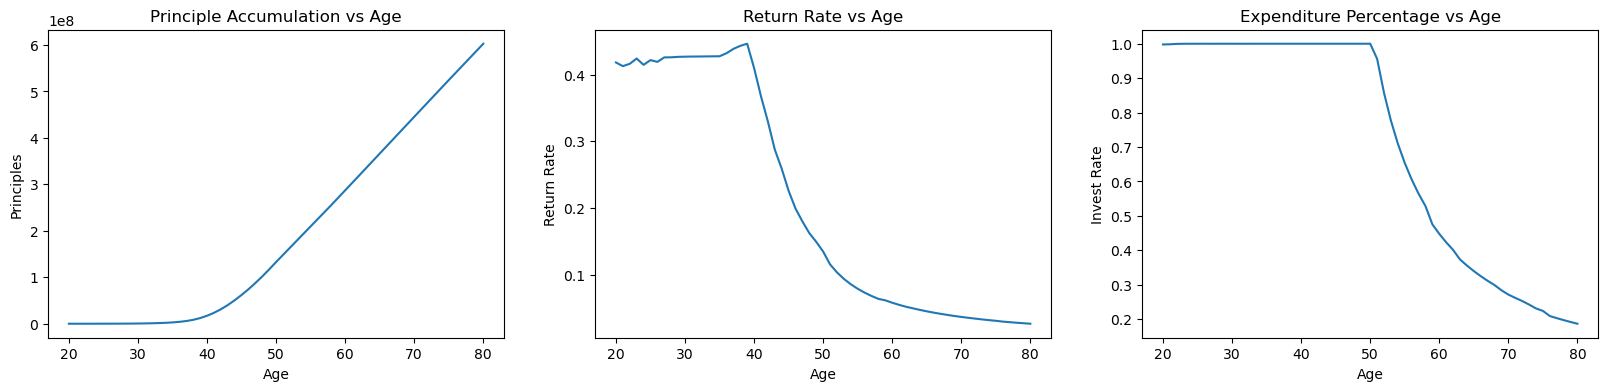

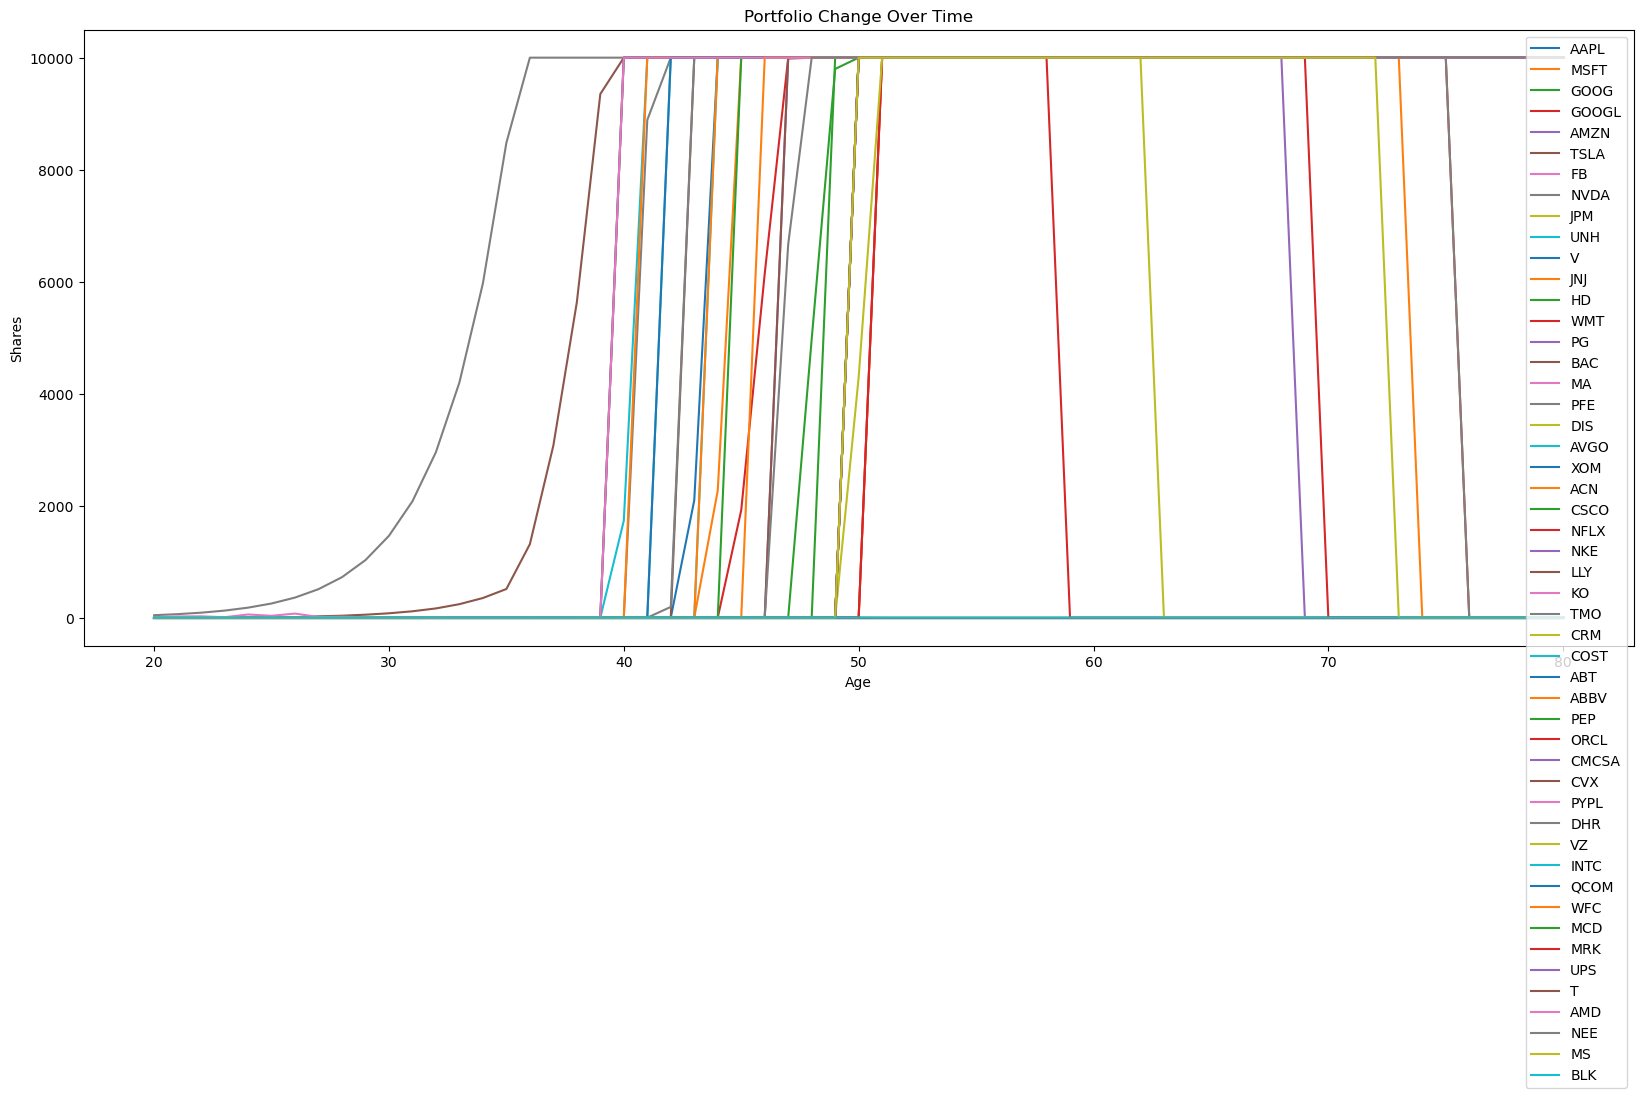

In [60]:
t_lambda = 75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

### 4.3.C 3-Month Investment Frame

In this section we analyzed what our model would look like when we set a 3-month invesment period as our optimal portfolio predictor. When we look at a normalized lambda = 0 in our risk model (which would be a risk-indifferent investor) we see a return rate that resembles our original risk model curve from our part 2 Mathematical Model around age 50. We can observe a moderate amount of portfolio chnages from ages 30 to 65 and a fairly constant rate of principle accumulation after age 45.

In general, the 3-month data collection compared to the 6-month data collection yielded:

$\bullet$ The return rate and principle accumulation are lower on-average.

$\bullet$ Most invesment trading occurs in the middle of an investors life (between ages 30 and 60).

$\bullet$ There is a large decrease in portfolio changes over an investors lifetime.

**Risk Indifferent Individual**

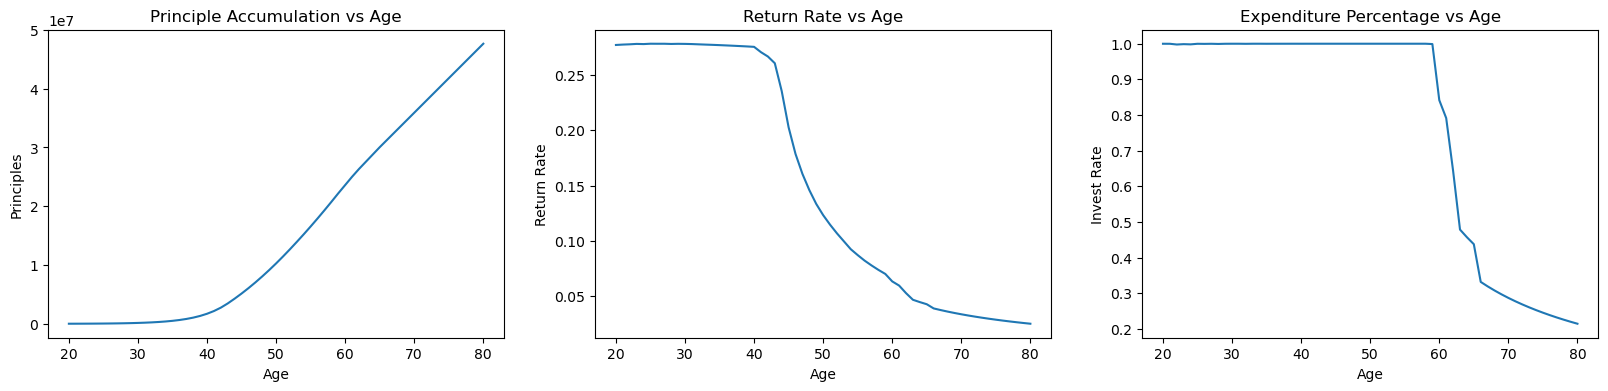

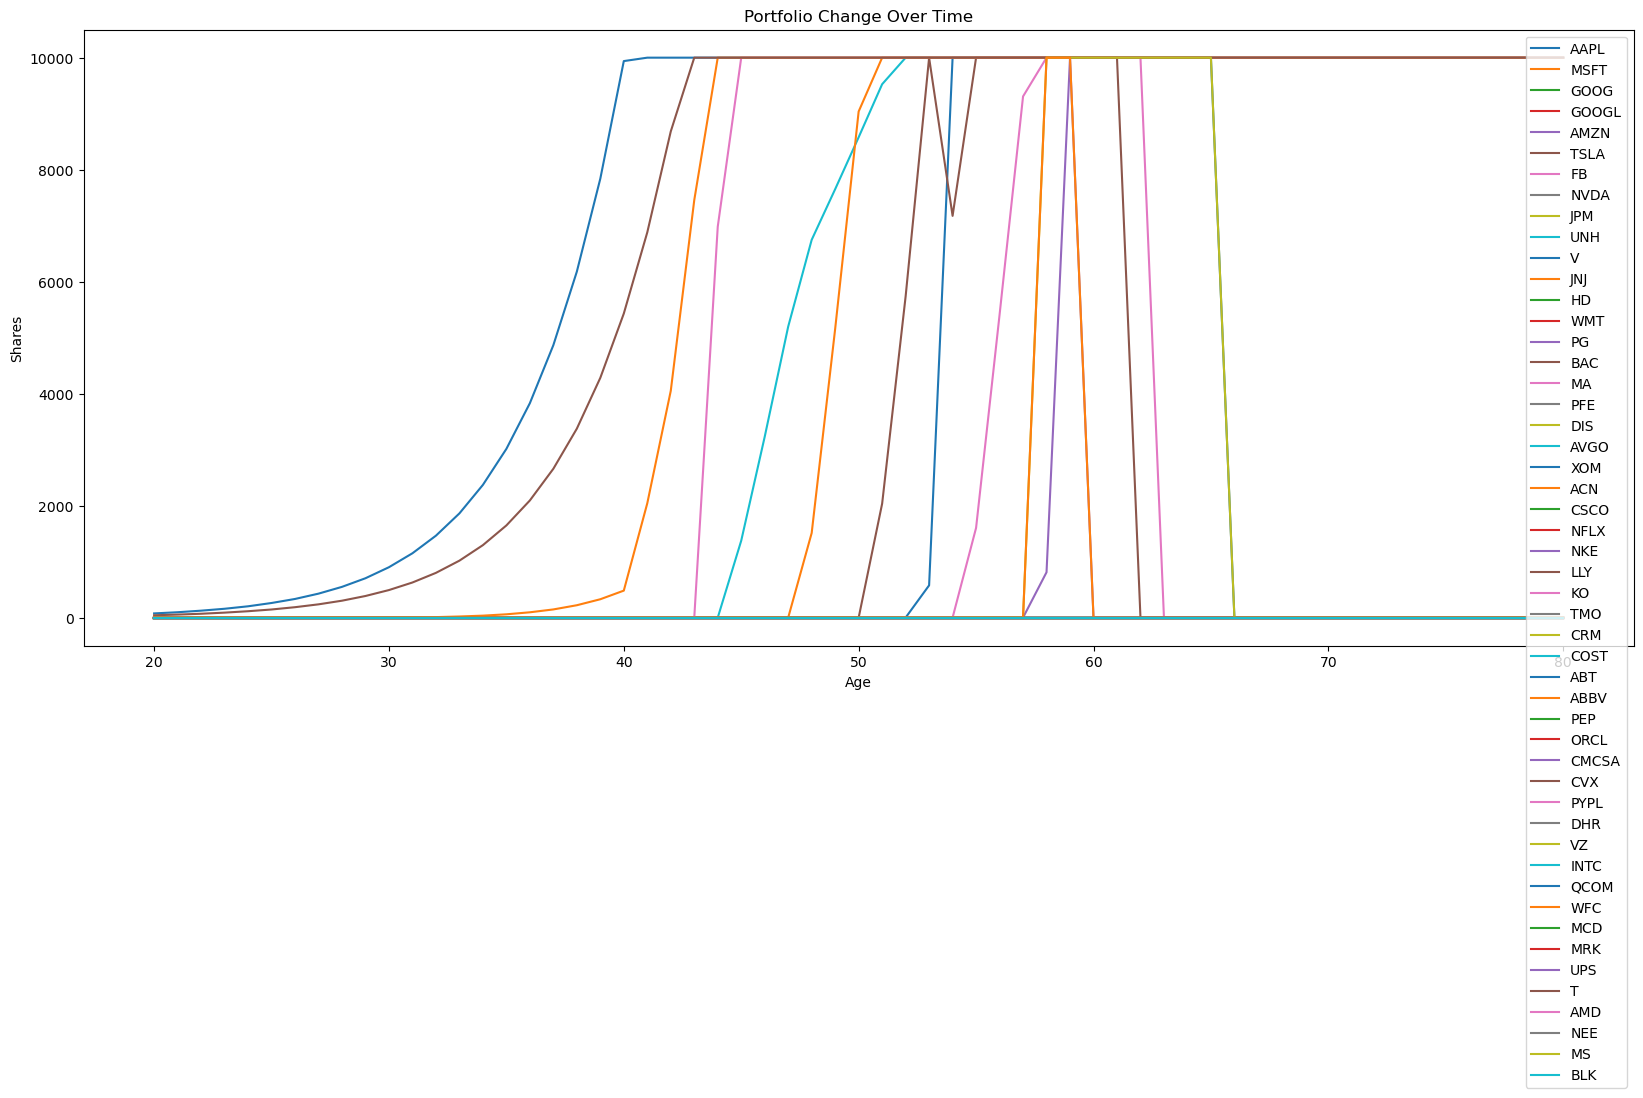

In [61]:
# 3 months
buyStart = Date(2021,10,25)
buyEnd = Date(2022,1,21)

sellStart = Date(2022,1,21)
sellEnd = Date(2022,4,20)

t_lambda = 0
t_cur_age = 20
t_retire = 80
ini_princ = 10000
shares_quota = 10000
print_portfolio = 0
print_csv = false

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Averse Individual**

Here we see that a Risk-Averse investor at lambda = -75 experiences a similar, but much smaller, return rate and total principle accumulation while the expediture and return rate curves drop off around age 70. There are large investments into only a few stocks from age 30 to 70. After 70 years of age, the stocks do not vary much and they mostly remain at the 10000 stock limit for the few initial stock invesments compared to a risk-indifferent investor in our 3-month data collection model.

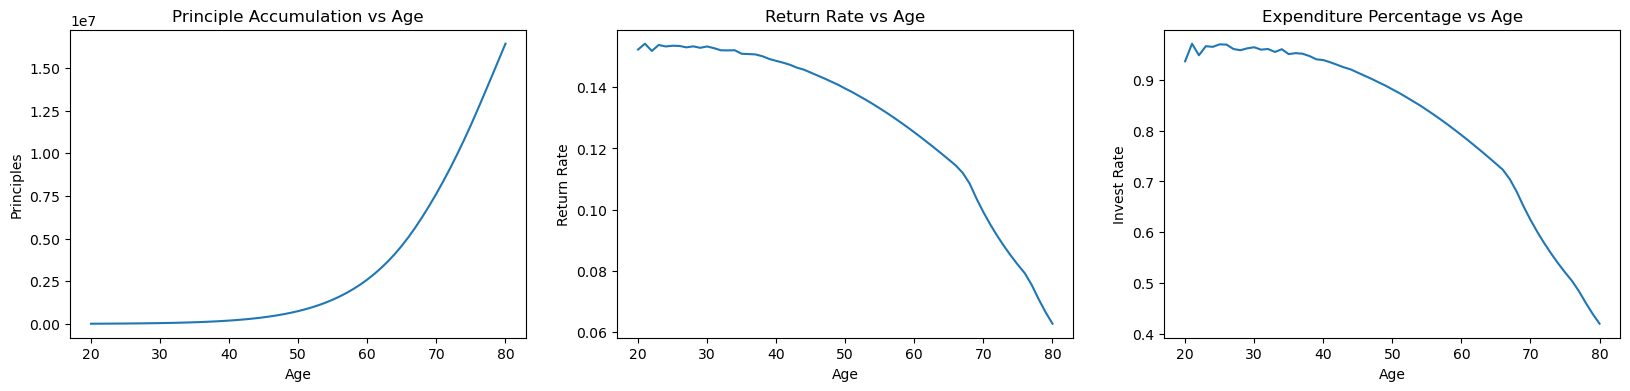

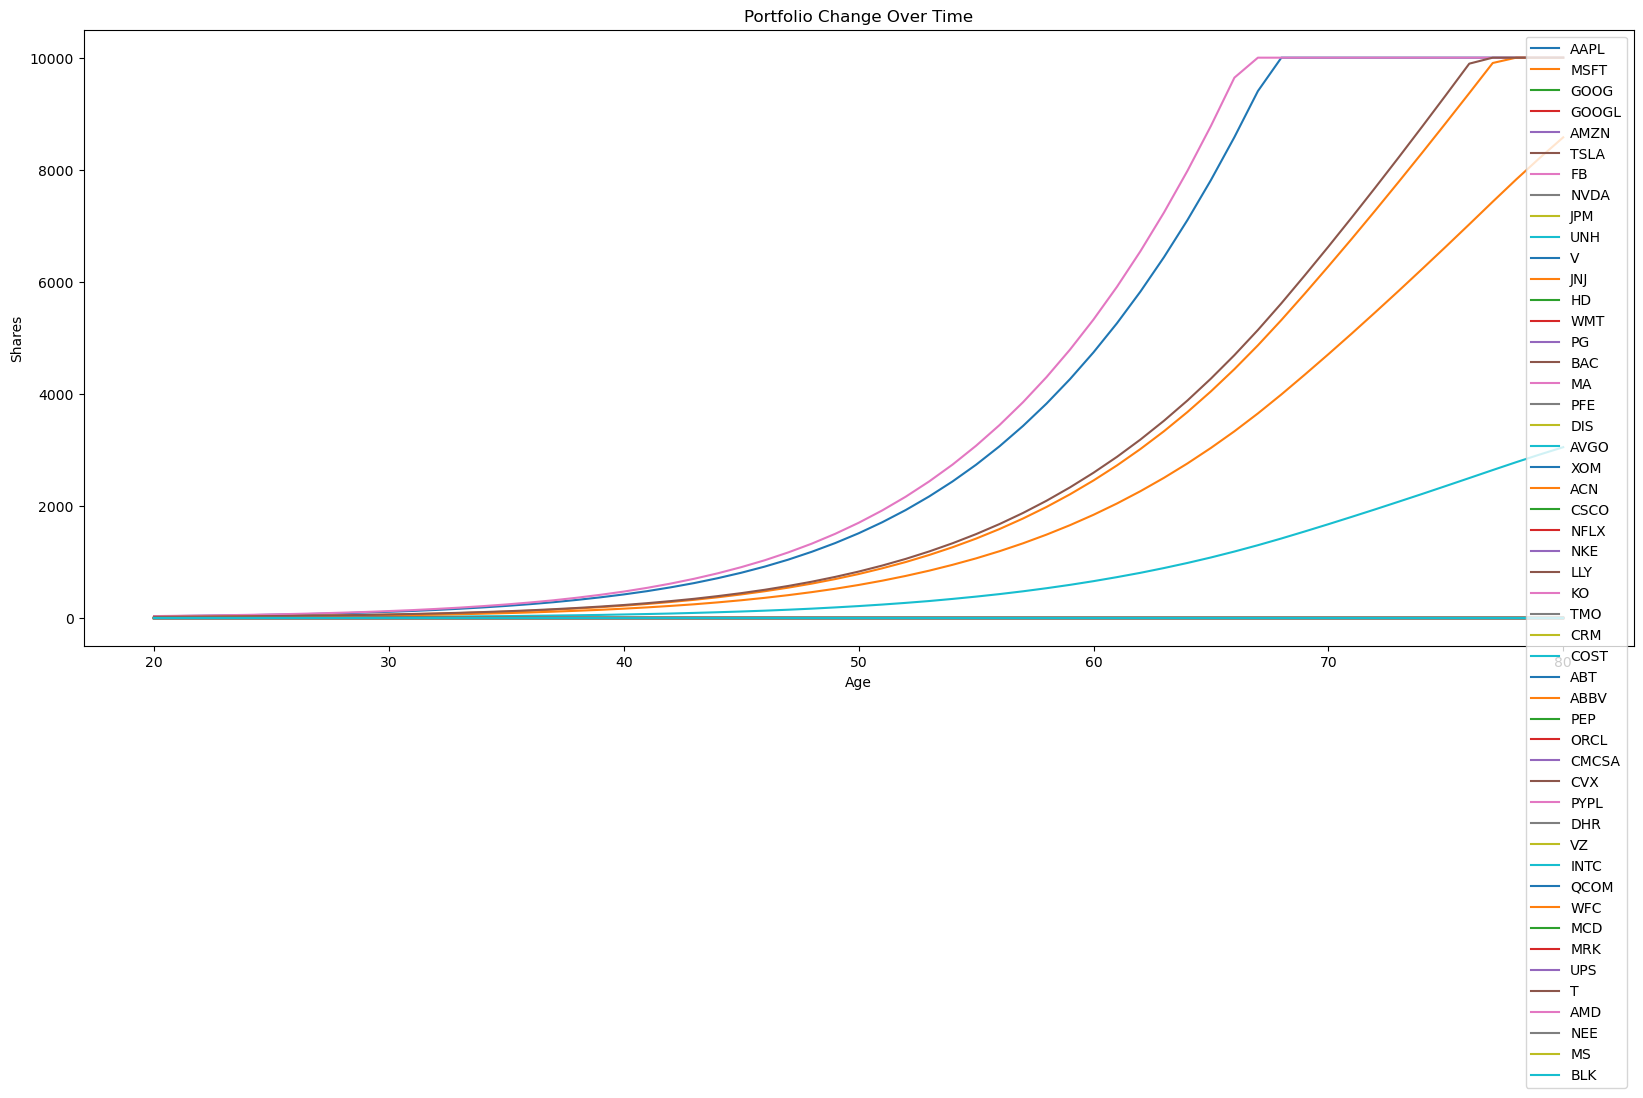

In [62]:
# 3 months Risk-Averse
t_lambda = -75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Loving Individual**

Here we see that a Risk-Loving investor at lambda = 75 also experiences a similar, but slightly larger, return rate and total principle accumulation later in life. Total expenditure experiences a much steeper drop which does not occur until age 70. More portfolio trades continue to occur from age 30 to age 80. There are several different investments into multiple stocks over their lifetime. After age 50, a risk-Loving investor sees a more dramatic drop in the starting return rate to the ending return rate as compared to risk-averse and risk-indifferent investors over the same 3-month data collection model.

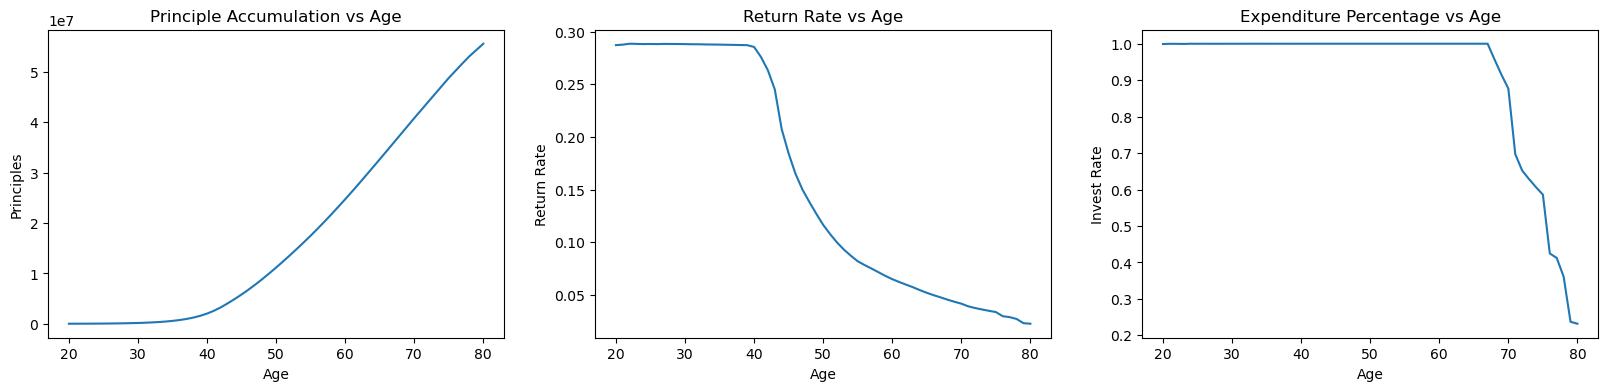

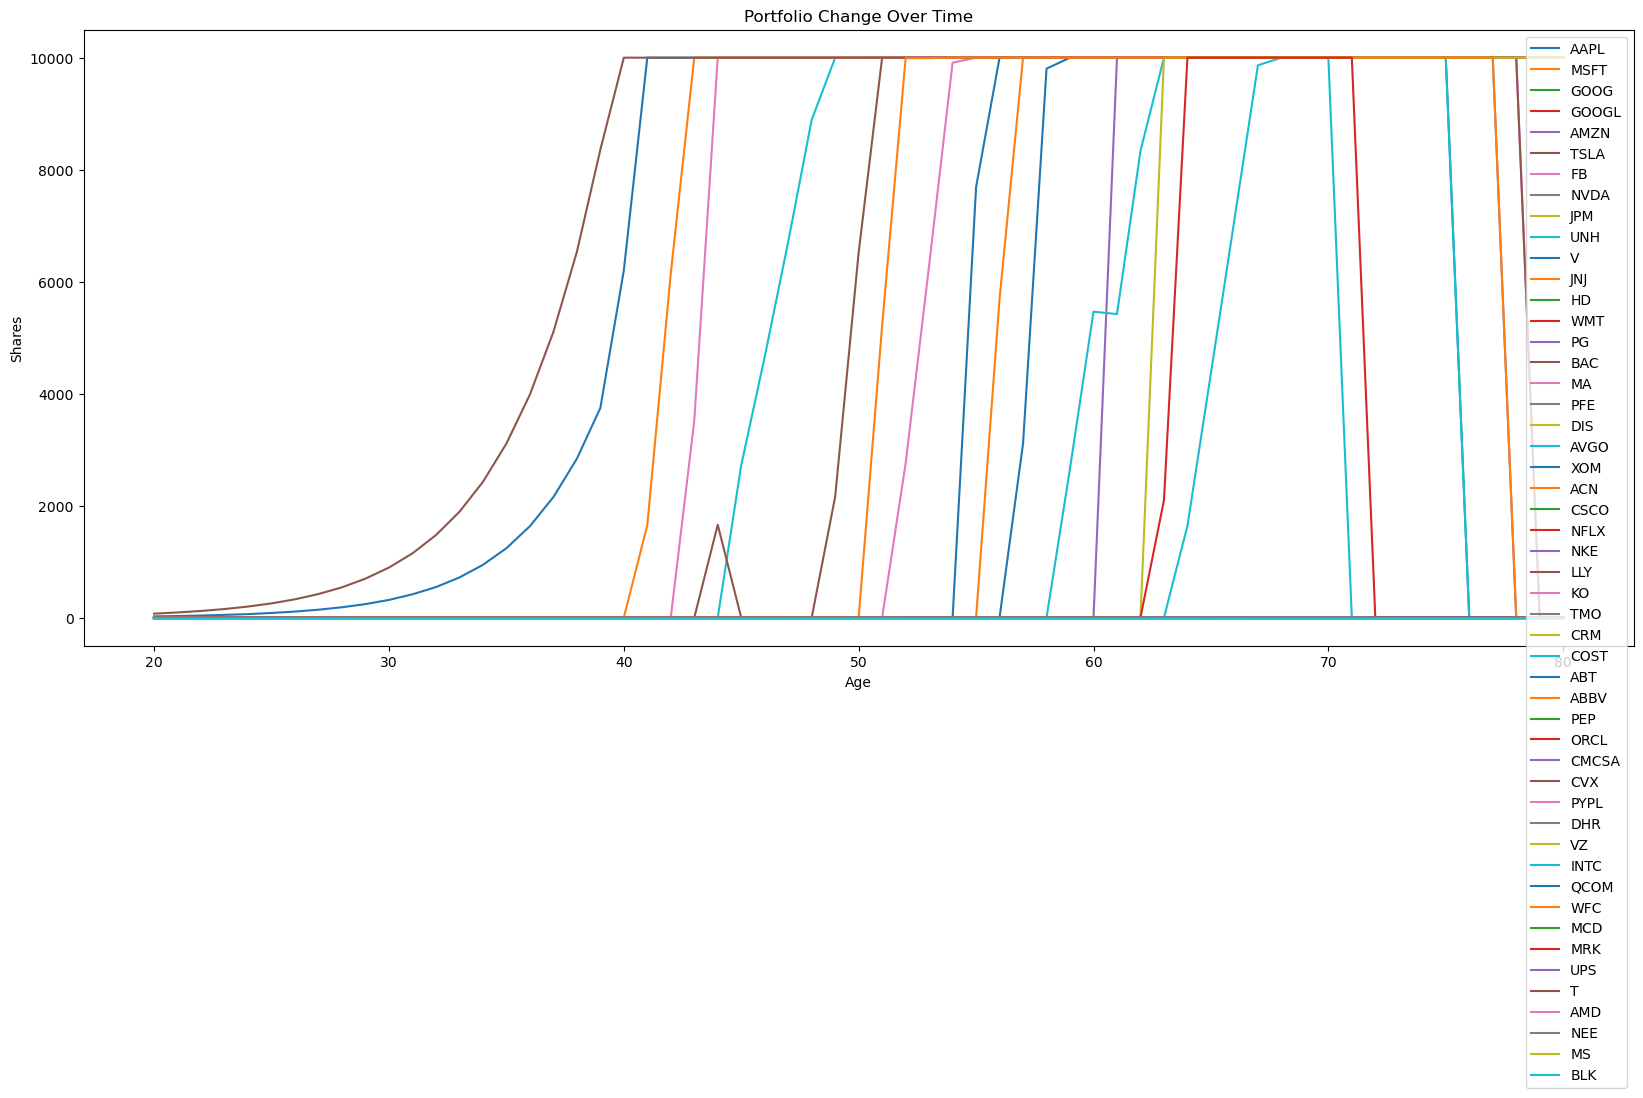

In [63]:
# 3 months Risk-Loving
t_lambda = 75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

### 4.3.D 1-Month Invesment Frame

In this section we analyzed what our model would look like when we set a 1-month invesment period as our optimal portfolio predictor. When we look at a normalized lambda = 0 in our risk model (which would be a risk-indifferent investor) we see a return rate that is relatively flat before sharply decreasing at age 60. We can observe a large amount of portfolio changes over a lifetime and a fairly constant rate of principle accumulation after age 60.

In general, the 1-month data collection compared to the 3-month data collection yielded:


$\bullet$ The return rate and principle accumulation are lower on-average.

$\bullet$ Most investment trading occurs later in life (after age 50).

$\bullet$ There is a large increase in portfolio changes over an investors lifetime.

**Risk Indifferent Individual**

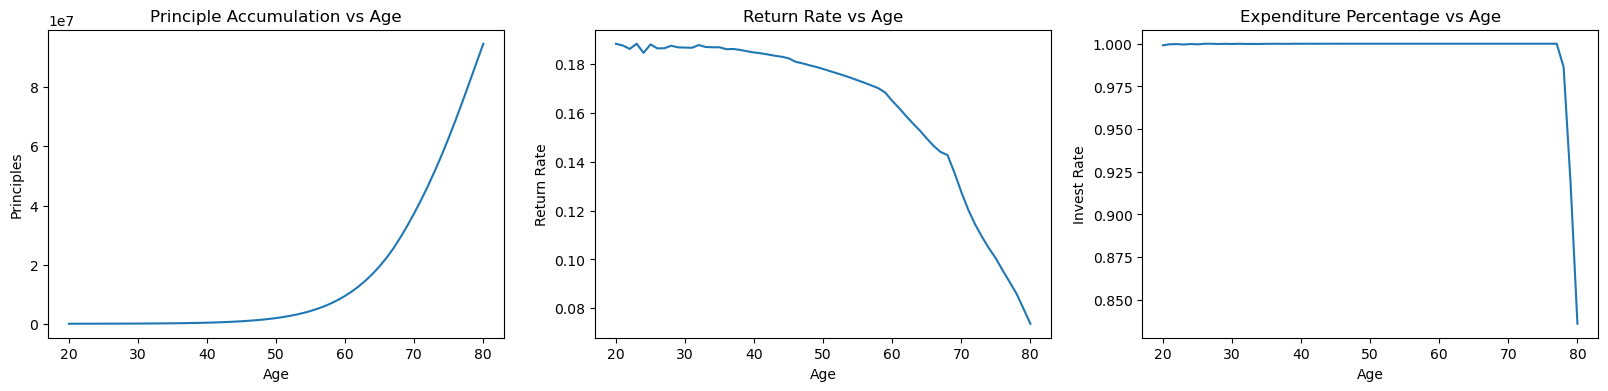

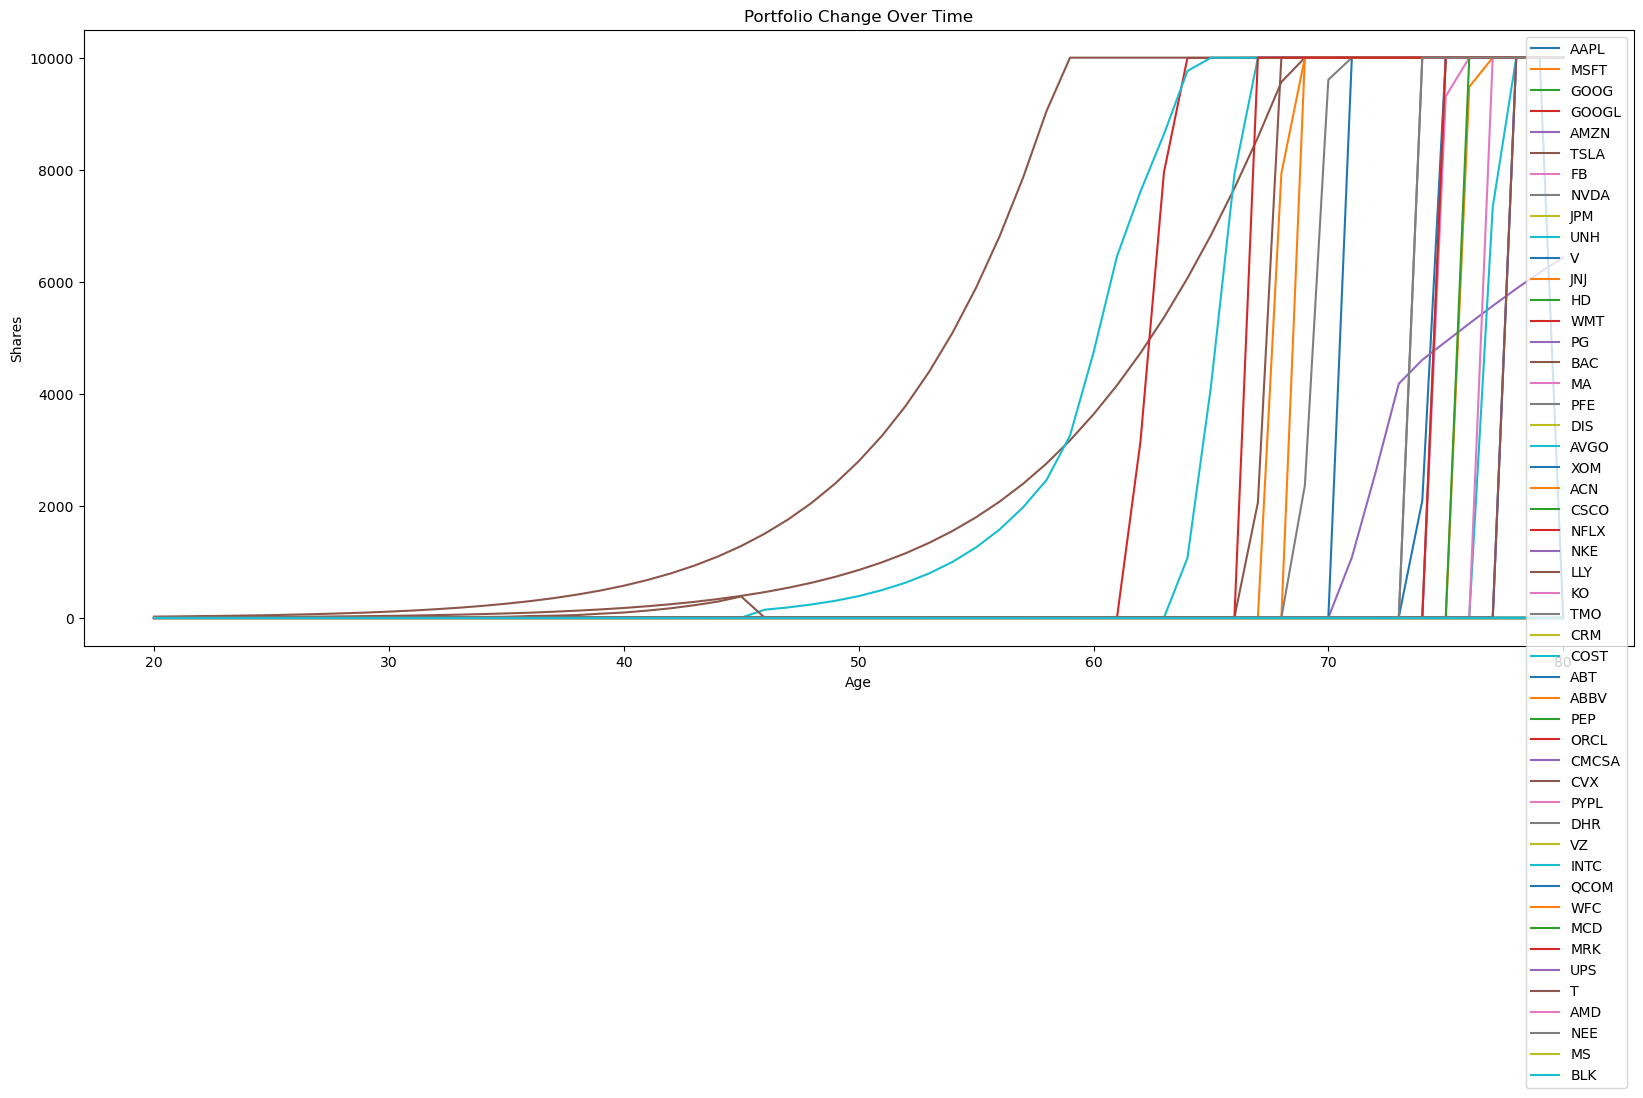

In [64]:
# 1 month risk-indifferent
buyStart = Date(2022,2,14)
buyEnd = Date(2022,3,18)

sellStart = Date(2022,3,21)
sellEnd = Date(2022,4,22)

t_lambda = 0
t_cur_age = 20
t_retire = 80
ini_princ = 10000
shares_quota = 10000
print_portfolio = 0
print_csv = false

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Averse Individual**

Here we see that a Risk-Averse investor at lambda = -75 experiences a much smaller return rate and total principle accumulation over a lifetime. The return rate and the expenditure percentage is much more volatile before age 50. The bulk of trading occurs between the ages of 60 and 80 while the portfolio does not change much before this period. The few invested stocks do not vary much and mostly remain below the 10000 stock limit before age 80 as compared to a risk-indifferent investor in our 1-month data collection model.

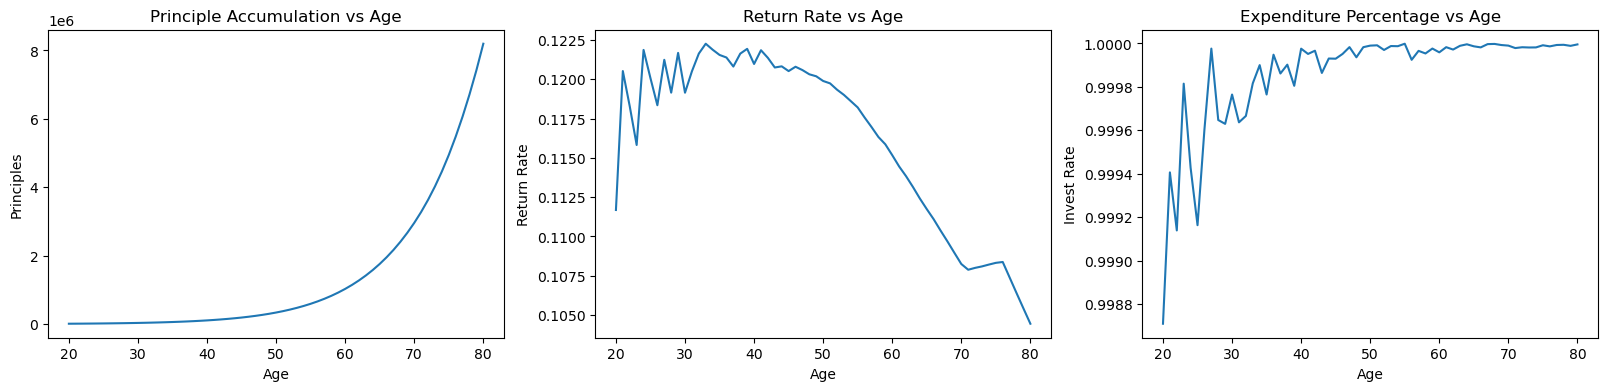

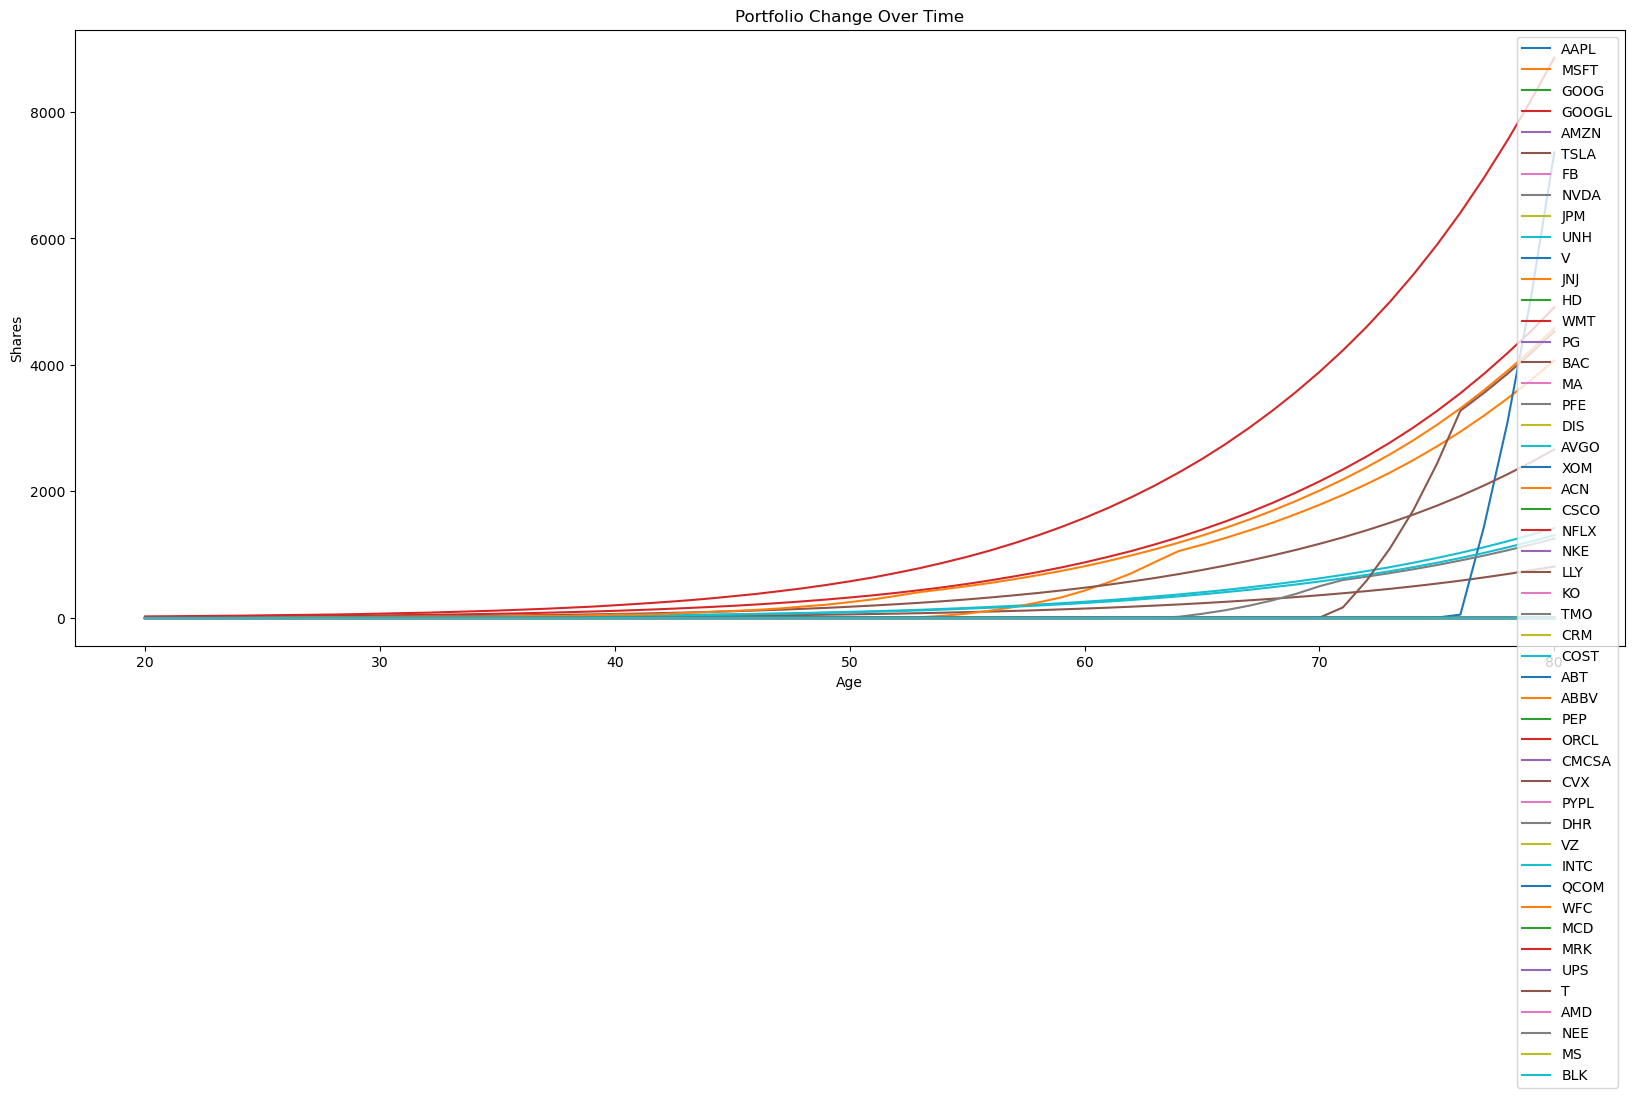

In [65]:
# 1 month Risk-Averse
t_lambda = -75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

**Risk Loving Individual**

Here we see that a Risk-Loving investor at lambda = 75 experiences a much larger return rate and total principle accumulation later in life. There are a huge number of portfoltio changes throughout the investors lifetime into different stocks even past age 70. Unlike risk-indifferent and risk-averse investors in our 1-month collection period, large amounts of invesment begin as early as age 40 and continue until age 80.

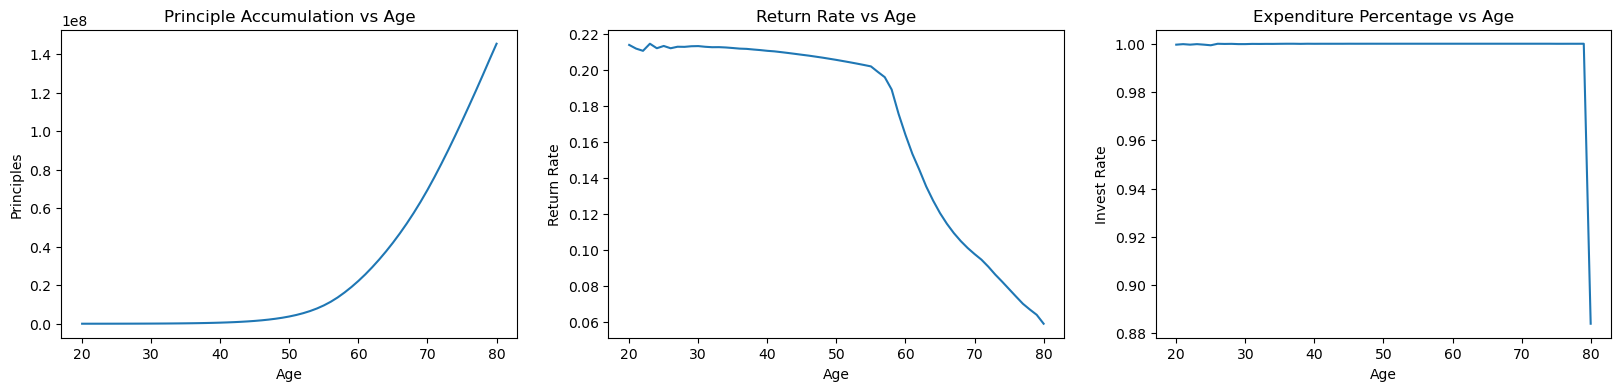

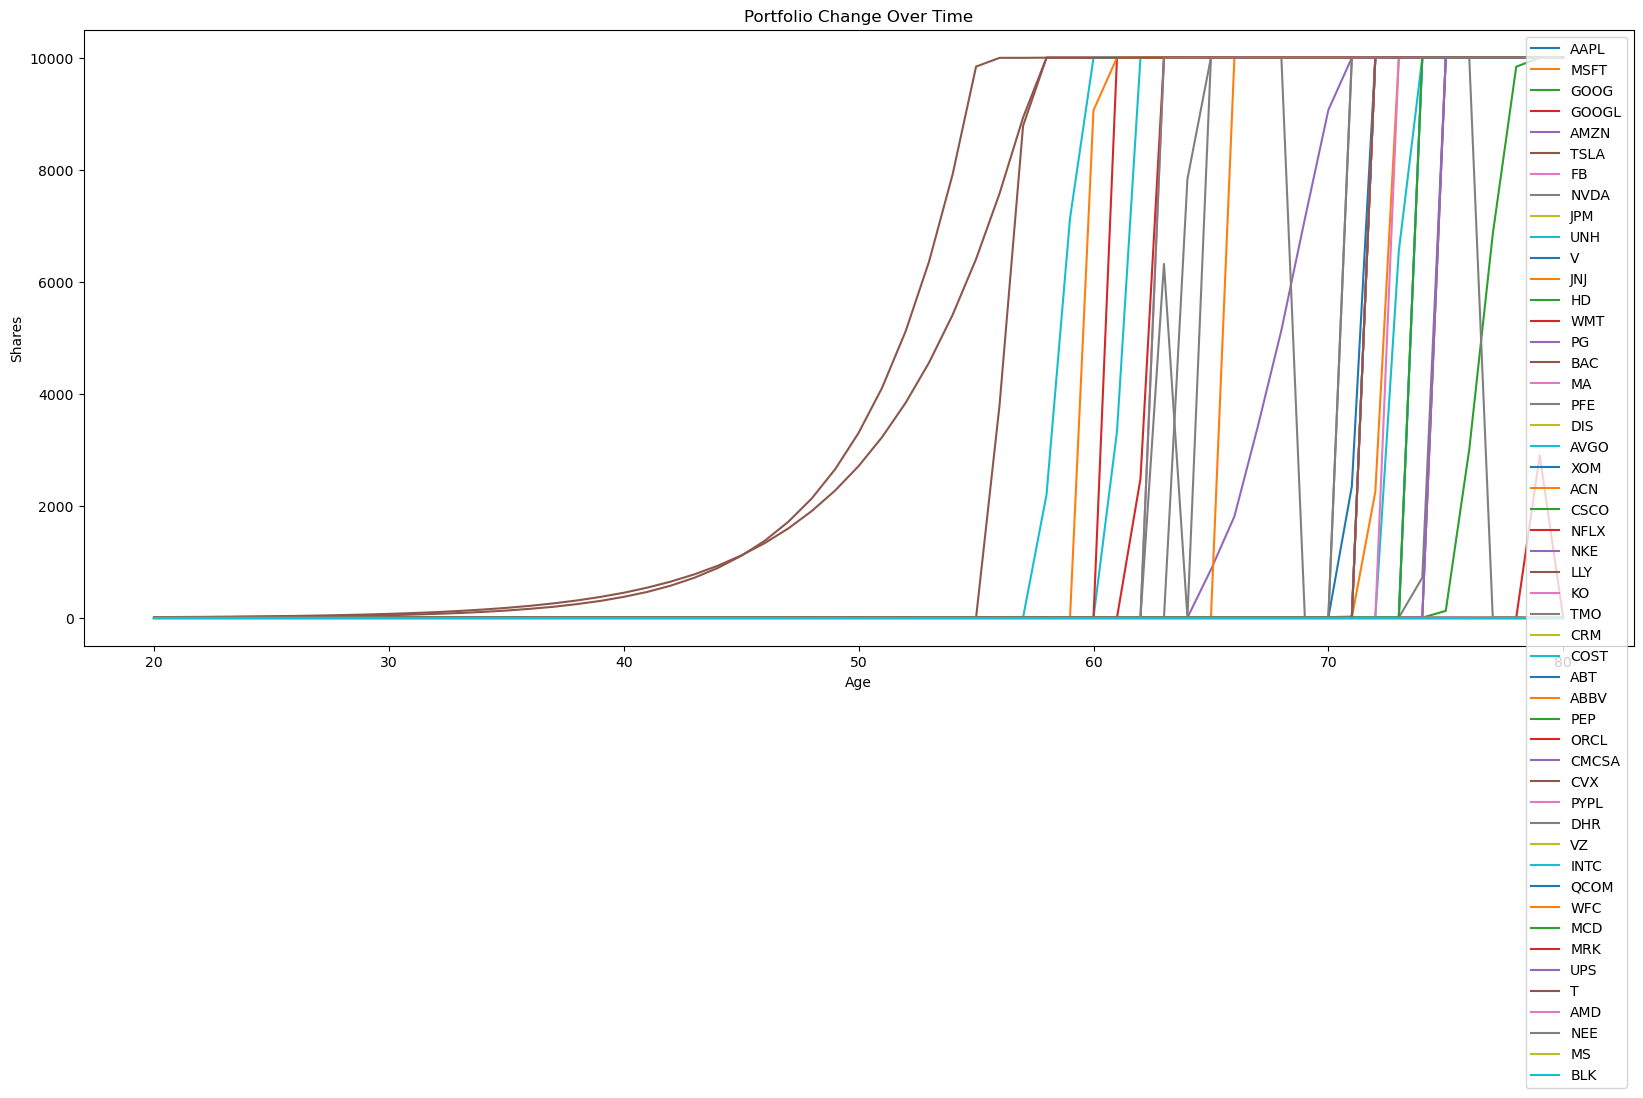

In [66]:
# 1 month Risk-Loving
t_lambda = 75

generatePortfolio(buyStart, buyEnd, sellStart, sellEnd, t_lambda, t_cur_age, t_retire, ini_princ, shares_quota, print_portfolio, print_csv)

## 5. Conclusion ##


1. We found that with a given investment period, a person with a higher initial $ \lambda $ will achieve a higher return rate at all ages and final wealth after retirement in comparison to a person with a lower $ \lambda $.


2. A general trend we spot is that a longer investment timeframe will incur a higher overall return rate with the best strategy over that time period.
  
  
3. The best strategy, if achieved year by year, will lead to the exponential growth of the investor's wealth. There will be point of time when the investor buys up all the qualified (according to the age-adjusted $ \lambda $) stocks to their shares and principle quota. At a certain point, there will be no more stock that satisfies the investor's criteria given by the age-adjusted $ \lambda $ other than the stocks within the investor's portfolio. After this point, the investor's expenditure rate will drop rapidly because their wealth keeps growing while they are not investing any portion of the new profit into the stock market again. As the age increases, some stocks in the portfolio are also going to be disqualified by the age-adjusted $ \lambda $.   
  

4. We found that the higher return rates and profit given by a longer investment timeframe will expedite the occurance of buying up all the eligible stocks to its shares limit according to that individual's age-adjusted $ \lambda $ value (mentioned above). The higher the return rate is, the earlier the individual is going to stop buying new stocks.  
  
  
5. The $ \lambda $ will mandate a person's principle quota as a percentage term, which in essence will set a minimum number of stocks to buy in order to minimize the risk. Because of that, a risk-averse person, with negative initial $ \lambda $, needs to buy more stocks together than a risk-loving person. This may further reduce the risk-averse investor's average return rate since they cannot go 'all-in.'  
    
     
6. If the investor does not have a principle high enough for him to buy the most lucrative stock, which can be expensive in terms of dollars per share, the investor may need to spend a few years accumulating wealth in order to achieve the maximum investment efficiency. This can also lead to less years in the peak investment efficiency, which will then lead to a lower final wealth.  
  
    
7. The shares quota can largely limit an individual's profitability. With a lower number of shares of a profitable stock, the investor will gain less money in nominal terms but have the same return rate.  
  
   
8. One limitation of our project is that we are just naively predicting the future performance of stocks based on their past performance. This is not always true in the real world. Since it is not exactly realistic to forecast the future performance of the stock market, our approach is only providing a best-effort prediction of building the best-strategy portfolio over one's lifetime.  
   
   
9. A more realistic implementation would be to let the model optimize over various markets such as bonds, crypto, real estate, etc. Involving these various markets would be more realistic given all of the accessible investment markets available today. We think this direction would be very doable in a future iteration of our project as we found a python library 'investpy' that could access the data for other markets, crypto, commodities etc. and formulate it without too much added complexity in a way that our model could optimize a portfolio including these additional invesment options.